# Предсказание длительности поездки на такси (решение задачи регрессии)

> Для корректной работы ссылок оглавления лучше смотреть проект здесь \
> https://nbviewer.org/github/experiment0/sf_data_science/blob/main/project_07/taxi_ride_duration_prediction.ipynb

## Оглавление

- [Постановка задачи](#item_intro)
- [Описание и загрузка данных](#item_load)
- [Знакомство с данными, базовый анализ и расширение данных](#item_prepare)
    - [Добавление признаков с датой и временем](#item_add_date_features)
    - [Добавление данных о праздничных днях](#item_add_holyday_features)
    - [Добавление данных из сервиса OSRM](#item_add_osrm_features)
    - [Добавление географических признаков](#item_add_geographical_features)
    - [Применение кластеризации по географическим координатам начала и конца поездки](#item_add_geo_cluster_features)
    - [Добавление данных о погоде](#item_add_weather_features)
    - [Заполнение пропусков](#item_fill_null)
    - [Удаление выбросов](#item_drop_outliers)
- [Разведывательный анализ данных (EDA)](#item_eda)
    - [Тепловая карта корреляции признаков](#item_corr)
    - [Распределение целевого признака в логарифмическом масштабе](#item_distribution_log_target)
    - [Распределение поездок между таксопарками](#item_vendor)
    - [Сравнение длительности поездки в логарифмическом масштабе в зависимости от таксопарка](#item_target_for_vendor)
    - [Сравнение длительности поездки в логарифмическом масштабе в зависимости от отправки сообщения таксопарку](#item_target_for_store_flag)
    - [Количество поездок в зависимости от часа дня](#item_count_for_hour)
    - [Медианная длительность поездки в зависимости от часа дня](#item_target_for_hour)
    - [Количество поездок в зависимости от дня недели](#item_count_for_day)
    - [Медианная длительность поездки в зависимости от дня недели](#item_target_for_day)
    - [Медианная длительность поездки в зависимости от дня недели и часа дня](#item_target_for_hour_and_day)
    - [Географическое расположение точек кластеров поездок](#item_geo_cluster)
- [Отбор и преобразование признаков](#item_fi)
    - [Удаление лишних признаков](#item_drop_features)
    - [Кодирование категориальных признаков](#item_encoding_features)
    - [Отбор лучших предикторов](#item_best_predictors)
    - [Нормализация признаков](#item_norm)
- [Решение задачи регрессии](#item_regression)
    - [Описание метрики (RMSLE)](#item_rmsle)
    - [Линейная регрессия](#item_lr)
    - [Полиномиальная регрессия второй степени](#item_pr2)
    - [Полиномиальная регрессия третьей степени](#item_pr3)
    - [Дерево решений](#item_tree)
    - [Случайный лес](#item_random_forest)
    - [Градиентный бустинг над деревьями решений](#item_gradient_boosting)
    - [Экстремальный градиентный бустинг `XGBoost`](#item_xg_boost)
    - [Экстремальный градиентный бустинг `XGBoost` на всех признаках](#item_xg_boost_all_features)
    - [Выбор лучшей модели](#item_best_model)
    - [Расчет медианной абсолютной ошибки (MeAE) для лучшей модели](#item_meae)
- [Предсказание для отложенного набора данных](#item_test_predict)
- [Вывод](#item_conclusion)

## Постановка задачи <a id="item_intro"></a>

Решается задача с платформы Kaggle [New York City Taxi Trip Duration](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/overview).\
По представленным данным необходимо сделать предсказание длительности поездки на такси в Нью Йорке.

Конечная точка не обязательно должна находиться в пределах города. \
Известно, что стоимость такси в США  рассчитывается на основе фиксированной ставки + тарифная стоимость, величина которой зависит от времени и расстояния. Тарифы варьируются в зависимости от города.

В свою очередь время поездки зависит от множества факторов таких как, откуда и куда совершается поездка, в какое время суток, погодных условий и так далее. 

**Бизнес-задача:** определить характеристики и с их помощью спрогнозировать длительность поездки такси.

**Техническая задача для специалиста Data Science:** построить модель машинного обучения, которая на основе предложенных характеристик клиента будет предсказывать числовой признак - время поездки такси. То есть решить задачу регрессии.

**Основные цели проекта:**
1. Сформировать набор данных на основе нескольких источников информации
2. Спроектировать новые признаки с помощью Feature Engineering и выявить наиболее значимые при построении модели
3. Исследовать предоставленные данные и выявить закономерности
4. Построить несколько моделей и выбрать из них наилучшую по заданной метрике
5. Спроектировать процесс предсказания времени длительности поездки для новых данных

## Описание и загрузка данных <a id="item_load"></a>

In [3]:
import numpy as np
import time
import datetime
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn import linear_model
from sklearn import preprocessing
from sklearn import model_selection
from sklearn import tree
from sklearn import ensemble
from sklearn import metrics
from sklearn import feature_selection
import optuna
import xgboost as xgb

%matplotlib inline

# Убираем вывод предупреждений
from warnings import simplefilter
simplefilter('ignore')

# Класс для обработки данных и имена полей таблицы
from classes.DataPreparation import DataPreparation, F

# Класс для построения графиков
from classes.Graphs import Graphs

# Вспомогательные функции общего назначения
from helpers.common import (
    get_rmsle, 
    print_rmsle,
    add_metric_to_data,
    get_minutes, 
    get_days,
    print_lead_time,
)

# Создадим объект класса DataPreparation для дальнейшей обработки данных
dataPreparation = DataPreparation()

# Объект класса Graphs для построения графиков
graphs = Graphs()

Исходные данные взяты [из соревнования](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data). \
Загрузим их.

In [5]:
train_data = pd.read_csv('./data/train.csv')

train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


Признаки можно разделить на следующие группы.

**Данные о клиенте и таксопарке:**
* `id` - уникальный идентификатор поездки
* `vendor_id` - уникальный идентификатор поставщика (таксопарка), связанного с записью поездки

**Временные характеристики:**
* `pickup_datetime` - дата и время, когда был включен счетчик поездки
* `dropoff_datetime` - дата и время, когда счетчик был отключен

**Географическая информация:**
* `pickup_longitude` -  долгота, на которой был включен счетчик
* `pickup_latitude` - широта, на которой был включен счетчик
* `dropoff_longitude` - долгота, на которой счетчик был отключен
* `dropoff_latitude` - широта, на которой счетчик был отключен

**Прочие признаки:**
* `passenger_count` - количество пассажиров в транспортном средстве (введенное водителем значение)
* `store_and_fwd_flag` - флаг, который указывает, сохранилась ли запись о поездке в памяти транспортного средства перед отправкой поставщику. \
Y - хранить и пересылать, N - не хранить и не пересылать поездку.

**Целевой признак:**
* `trip_duration` - продолжительность поездки в секундах

## Знакомство с данными, базовый анализ и расширение данных <a id="item_prepare"></a>

Сначала познакомимся с данными. \
А затем подгрузим дополнительные источники данных и расширим исходный датасет. 

In [6]:
print('Размер таблицы: ', train_data.shape)

Размер таблицы:  (1458644, 11)


Посмотрим на типы данных.

In [7]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
 #   Column              Non-Null Count    Dtype  
---  ------              --------------    -----  
 0   id                  1458644 non-null  object 
 1   vendor_id           1458644 non-null  int64  
 2   pickup_datetime     1458644 non-null  object 
 3   dropoff_datetime    1458644 non-null  object 
 4   passenger_count     1458644 non-null  int64  
 5   pickup_longitude    1458644 non-null  float64
 6   pickup_latitude     1458644 non-null  float64
 7   dropoff_longitude   1458644 non-null  float64
 8   dropoff_latitude    1458644 non-null  float64
 9   store_and_fwd_flag  1458644 non-null  object 
 10  trip_duration       1458644 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


Здесь видно, что признаки с датой и временем `pickup_datetime` и `dropoff_datetime` нужно привести к типу `datetime`.\
Позже сделаем это.

Посмотрим, есть ли пропуски в данных.

In [8]:
train_data.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
dtype: int64

Явных пропусков нет.

**Посмотрим на некоторые характеристики распределения данных о поездках.**

In [9]:
print('Характеристики распределения времени поездок в минутах:')

train_data[F.TRIP_DURATION.value].describe().apply(get_minutes)

Характеристики распределения времени поездок в минутах:


count    24310.73
mean        15.99
std         87.29
min          0.02
25%          6.62
50%         11.03
75%         17.92
max      58771.37
Name: trip_duration, dtype: float64

In [10]:
print(f'Максимальная длительность поездки: {get_days(train_data[F.TRIP_DURATION.value].max())} дней')

Максимальная длительность поездки: 40.81 дней


Минимальное время поездки близкое к 0 и максимальное в 40 дней говорит о том, что в данных есть выбросы.\
Удалим их позже.

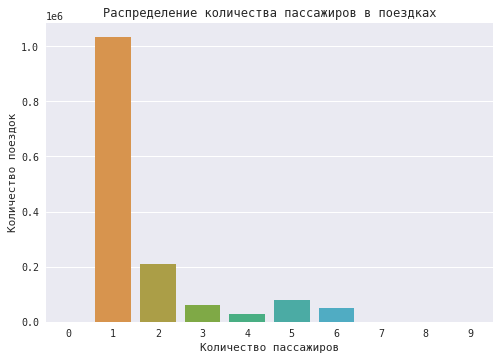

In [11]:
graphs.show_countplot(
    train_data, 
    F.PASSENGER_COUNT.value, 
    'Распределение количества пассажиров в поездках', 
    'Количество пассажиров', 
    'Количество поездок'
)

Чаще всего ездят 1-2 пассажира. Максимальное количество пассажиров 9.

### Добавление признаков с датой и временем <a id="item_add_date_features"></a>

Переведем признаки `pickup_datetime` и `dropoff_datetime` в формат `datetime`.\
И сформируем из них новые признаки:
- `pickup_date` - дата включения счётчика/начала поездки (без времени)
- `pickup_hour` - час включения счётчика
- `pickup_day_of_week` - день недели, в который был включён счётчик (0 - понедельник)

In [12]:
# Приведем pickup_datetime и dropoff_datetime к типу datetime
# и сформируем указанные выше признаки
train_data = dataPreparation.add_datetime_features(train_data)

train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5


Определим даты, за которые представлены данные.

In [13]:
print('Наименьшая дата: ', train_data[F.PICKUP_DATETIME.value].min())
print('Наибольшая дата: ', train_data[F.PICKUP_DATETIME.value].max())

Наименьшая дата:  2016-01-01 00:00:17
Наибольшая дата:  2016-06-30 23:59:39


In [14]:
print(
    'В среднем совершалось поездок в день: ',
    round(
        train_data.groupby(F.PICKUP_DATE.value).count()[F.ID.value].mean()
    )
)

В среднем совершалось поездок в день:  8015


### Добавление данных о праздничных днях <a id="item_add_holyday_features"></a>

От того, является ли день праздничным, часто зависит ситуация на дорогах. \
Большое количество автомобилей создаёт пробки \
и потенциально увеличивает длительность совершаемой на такси поездки.

Добавим в датасет информацию о том, является ли день праздничным. \
В таблице [holyday_data.csv](https://disk.yandex.ru/d/Zh1pZo_f3QQUtA) содержатся даты всех праздничных дней в Америке за 2016 год  и содержат три столбца:

- `day` — день недели;
- `date` — дата;
- `holiday` — наименование праздника.

In [15]:
holiday_data = pd.read_csv('./data/holiday_data.csv', sep=';')
holiday_data

,day,date,holiday
0,Friday,2016-01-01,New Years Day
1,Monday,2016-01-18,Martin Luther King Jr. Day
2,Friday,2016-02-12,Lincoln's Birthday
3,Monday,2016-02-15,Presidents' Day
4,Sunday,2016-05-08,Mother's Day
5,Monday,2016-05-30,Memorial Day
6,Sunday,2016-06-19,Father's Day
7,Monday,2016-07-04,Independence Day
8,Monday,2016-09-05,Labor Day
9,Monday,2016-10-10,Columbus Day


В 2016 году в США было 14 праздничных дней.

Добавим в нашу таблицу новый признак 
- `is_pickup_in_holiday` - начата ли поездка в праздничный день (1 — да, 0 — нет)

In [16]:
# Запомним таблицу с праздниками
dataPreparation.set_holiday_data(holiday_data)
# Добавим признак, является ли день праздничным
train_data = dataPreparation.add_holiday_feature(train_data)

train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,is_pickup_in_holiday
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0,0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6,0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1,0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2,0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5,0


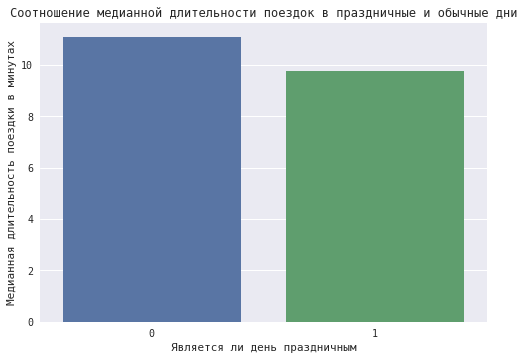

In [17]:
median_trip_duration_on_holidays = \
    train_data.groupby(F.IS_PICKUP_IN_HOLIDAY.value)[F.TRIP_DURATION.value].median().apply(get_minutes)
    
graphs.show_barplot(
    median_trip_duration_on_holidays, 
    'Соотношение медианной длительности поездок в праздничные и обычные дни', 
    'Является ли день праздничным', 
    'Медианная длительность поездки в минутах'
)

В праздничные дни медианная длительность поездок немного меньше.

### Добавление данных из сервиса OSRM <a id="item_add_osrm_features"></a>

Перейдем к географическим признакам.

В данных есть столбцы, содержащие информацию о широте и долготе. \
Зная широту и долготу начальной и конечной точек маршрута, мы можем воспользоваться **OSRM API**.

> **[OSRM (Open Source Routing Machine)](https://en.wikipedia.org/wiki/Open_Source_Routing_Machine)** — это открытый бесплатный ресурс, \
который позволяет построить оптимальный кусочно-линейный путь из точки А в точку B, \
а также узнать его примерную длительность и длину. \
[Документация API сервиса](https://www.thinkdatascience.com/post/2020-03-03-osrm/osrm/).

Выгрузка данных из OSRM подготовлена заранее, можно скачать ее [здесь](https://disk.yandex.ru/d/_YOYziN_B-a4-Q).\
Для нас интересны следующие столбцы:

- `id` — идентификатор поездки (совпадает с идентификатором в нашей таблице);
- `total_distance` — кратчайшее дорожное расстояние (в метрах) из точки, в которой был включён счётчик, \
до точки, в которой счётчик был выключен (согласно OSRM);
- `total_travel_time` — наименьшее время поездки (в секундах) из точки, в которой был включён счётчик, \
до точки, в которой счётчик был выключен (согласно OSRM);
- `number_of_steps` — количество дискретных шагов, которые должен выполнить водитель \
(поворот налево/поворот направо/ехать прямо и т. д.).

In [18]:
osrm_data = pd.read_csv('./data/osrm_data_train.csv')
osrm_data.head()

,id,starting_street,end_street,total_distance,total_travel_time,number_of_steps,street_for_each_step,distance_per_step,travel_time_per_step,step_maneuvers,step_direction,step_location_list
0,id2875421,Columbus Circle,East 65th Street,2009.1,164.9,5,Columbus Circle|Central Park West|65th Street ...,0|576.4|885.6|547.1|0,0|61.1|60.1|43.7|0,depart|rotary|turn|new name|arrive,left|straight|right|straight|arrive,"-73.982316,40.767869|-73.981997,40.767688|-73...."
1,id2377394,2nd Avenue,Washington Square West,2513.2,332.0,6,2nd Avenue|East 13th Street|5th Avenue|Washing...,877.3|836.5|496.1|164.2|139.1|0,111.7|109|69.9|25.8|15.6|0,depart|turn|turn|end of road|continue|arrive,none|right|left|right|left|arrive,"-73.980429,40.73857|-73.985444,40.731658|-73.9..."
2,id3504673,Greenwich Street,Broadway,1779.4,235.8,4,Greenwich Street|Park Place|Broadway|Broadway,644.2|379.9|755.3|0,80.5|50.8|104.5|0,depart|turn|end of road|arrive,left|left|right|arrive,"-74.010145,40.719982|-74.011527,40.714294|-74...."
3,id2181028,Broadway,West 81st Street,1614.9,140.1,5,Broadway|West 86th Street|Columbus Avenue|West...,617|427.4|412.2|158.3|0,56|36|37.8|10.3|0,depart|turn|turn|turn|arrive,right|left|right|left|arrive,"-73.972998,40.793187|-73.976607,40.788361|-73...."
4,id0801584,Lexington Avenue,West 31st Street,1393.5,189.4,5,Lexington Avenue|East 27th Street|Madison Aven...,18.9|311.9|313.3|749.4|0,6.3|42.9|48.4|91.8|0,depart|turn|turn|turn|arrive,right|right|right|left|arrive,"-73.982805,40.742173|-73.982914,40.742024|-73...."


Время поездки, вычисляемое с помощью OSRM, не является истинным временем поездки, \
так как оно вычисляется по кратчайшему пути при идеальных условиях: \
отсутствие пробок, погодных влияний и других внешних факторов. 

Добавим перечисленные выше признаки в нашу таблицу.

In [19]:
# Запомним таблицу с данными из OSRM
dataPreparation.set_osrm_data(osrm_data)
# Добавим перечисленные выше столбцы
train_data = dataPreparation.add_osrm_features(train_data)

train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,is_pickup_in_holiday,total_distance,total_travel_time,number_of_steps
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0,0,2009.1,164.9,5.0
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6,0,2513.2,332.0,6.0
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1,0,11060.8,767.6,16.0
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2,0,1779.4,235.8,4.0
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5,0,1614.9,140.1,5.0


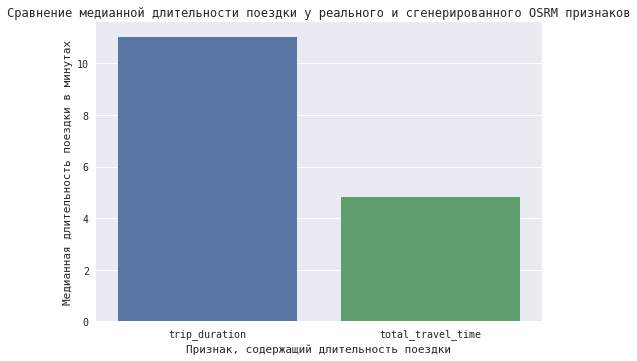

In [20]:
graphs.show_barplot(
    train_data[[F.TRIP_DURATION.value, F.TOTAL_TRAVEL_TIME.value]].median().apply(get_minutes),
    'Сравнение медианной длительности поездки у реального и сгенерированного OSRM признаков',
    'Признак, содержащий длительность поездки',
    'Медианная длительность поездки в минутах',
)

Реальное медианное значение значительно больше, чем сгерерированное OSRM.

Некоторые данные не удалось выгрузить из веб источника.\
Посмотрим на количество строк с пропусками.

In [21]:
train_data[train_data.isna().any(axis = 1)]

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,is_pickup_in_holiday,total_distance,total_travel_time,number_of_steps
1133561,id3008062,2,2016-06-23 19:04:09,2016-06-23 19:04:35,1,-73.787537,40.64241,-73.787811,40.642109,N,26,2016-06-23,19,3,0,NaN,NaN,NaN


Позже заполним эти пропуски медианным значением.

### Добавление географических признаков <a id="item_add_geographical_features"></a>

Если рассматривать Землю как сферу, то, зная широту и долготу начальной и конечной точек маршрута, \
можно вычислить географическое расстояние между точками на сфере, \
а также узнать направление движения автомобиля.

Добавим признак, который содержит расстояние между двумя точками по [формуле гаверсинуса](https://www.geeksforgeeks.org/haversine-formula-to-find-distance-between-two-points-on-a-sphere/). 

Данная формула определяет кратчайшее расстояние между двумя точками на сфере, \
если известны широта и долгота каждой из точек. \
Геометрически это длина кратчайшей дуги, связывающей точки на сфере.

Зная начальную и конечную точку маршрута, \
мы можем вычислить направление движения автомобиля (угол пеленга) по формуле:

$$ \alpha = arctg (\frac{sin (\lambda_2 - \lambda_1) cos (\varphi_2)}{cos (\varphi_1) sin (\varphi_2) - sin (\varphi_1) cos (\varphi_2) cos (\lambda_2 - \lambda_1)}), $$

где $\alpha$ — угол направления движения от первой точки ко второй \
(может измеряться как в радианах, так и в градусах).

Функции для поиска данных величин реализованы в файле `./helpers/geography.py`

- `get_haversine_distance` - вычисляет расстояние между двумя точками по формуле гаверсинуса (в километрах).
- `get_angle_direction` - вычисляет угол направления движения (в градусах).

Обе эти функции используются в методе `add_geographical_features` класса `DataPreparation`.\
Который добавляет два новых признака:

- `haversine_distance` - расстояние по формуле Гаверсинуса между точкой, в которой был включён счетчик, \
и точкой, в которой счётчик был выключен
- `angle_direction` - направление движения из точки, в которой был включён счётчик, \
в точку, в которой счётчик был выключен

Воспользуемся методом для добавления признаков.

In [22]:
train_data = dataPreparation.add_geographical_features(train_data)

train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration,pickup_date,pickup_hour,pickup_day_of_week,is_pickup_in_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,angle_direction
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455,2016-03-14,17,0,0,2009.1,164.9,5.0,1.498521,99.970196
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663,2016-06-12,0,6,0,2513.2,332.0,6.0,1.805507,-117.153768
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124,2016-01-19,11,1,0,11060.8,767.6,16.0,6.385098,-159.680165
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429,2016-04-06,19,2,0,1779.4,235.8,4.0,1.485498,-172.737700
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435,2016-03-26,13,5,0,1614.9,140.1,5.0,1.188588,179.473585


### Применение кластеризации по географическим координатам начала и конца поездки <a id="item_add_geo_cluster_features"></a>

С помощью алгоритма кластеризации K-Means сгруппируем все поездки в зависимости от координат начала и конца (долготы и широты).\
Так мы добавим информацию о районах, в которых находятся точки старта и конца поездки.

Гипотеза состоит в том, что длительность поездки будет зависеть от того, \
к какому географическому кластеру будет принадлежать поездка.

Возьмём десять кластеров.

Обучение объекта `KMeans` для кластеризации реализовано в методе `set_geo_cluster_kmeans` класса `DataPreparation`.\
Добавление признака с кластером - в методе `add_geo_cluster_feature` того же класса.\
Метод добавляет новый признак:
- `geo_cluster` - географический кластер, к которому относится поездка \
(определенный с помощью KMeans на тренировочном наборе данных)

Воспользуемся этими методами.

In [23]:
dataPreparation.set_geo_cluster_kmeans(train_data)
train_data = dataPreparation.add_geo_cluster_feature(train_data)

train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,pickup_date,pickup_hour,pickup_day_of_week,is_pickup_in_holiday,total_distance,total_travel_time,number_of_steps,haversine_distance,angle_direction,geo_cluster
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,2016-03-14,17,0,0,2009.1,164.9,5.0,1.498521,99.970196,9
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,2016-06-12,0,6,0,2513.2,332.0,6.0,1.805507,-117.153768,4
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,2016-01-19,11,1,0,11060.8,767.6,16.0,6.385098,-159.680165,4
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,2016-04-06,19,2,0,1779.4,235.8,4.0,1.485498,-172.737700,4
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,2016-03-26,13,5,0,1614.9,140.1,5.0,1.188588,179.473585,9


### Добавление данных о погоде <a id="item_add_weather_features"></a>

Важным фактором, потенциально влияющим на дорожное движение, является погода. \
Например, снег и дождь могут затруднять движение и увеличивать время поездки.

[Здесь](https://disk.yandex.ru/d/wox1x1_5biSstA) таблица с информацией о погодных условиях в Нью-Йорке в 2016 году. \
Нам интересны следующие столбцы:

- `date` — дата измерения (соответствует полю `pickup_date` в нашей таблице);
- `hour` — час измерения (соответствует полю `pickup_hour` в нашей таблице);
- `temperature` — температура;
- `visibility` — видимость;
- `wind speed` — средняя скорость ветра;
- `precip` — количество осадков;
- `events` — погодные явления: 
    - `Rain` — дождь, 
    - `Snow` — снег, 
    - `Fog` — туман, 
    - `None` — отсутствие погодных явлений.

In [24]:
weather_data = pd.read_csv('./data/weather_data.csv')
weather_data.head()

,time,temperature,windchill,heat index,humidity,pressure,dew Point,visibility,wind dir,wind speed,gust speed,precip,events,conditions,date,hour
0,2015-12-31 02:00:00,7.8,7.1,NaN,0.89,1017.0,6.1,8.0,NNE,5.6,0.0,0.8,None,Overcast,2015-12-31,2
1,2015-12-31 03:00:00,7.2,5.9,NaN,0.90,1016.5,5.6,12.9,Variable,7.4,0.0,0.3,None,Overcast,2015-12-31,3
2,2015-12-31 04:00:00,7.2,NaN,NaN,0.90,1016.7,5.6,12.9,Calm,0.0,0.0,0.0,None,Overcast,2015-12-31,4
3,2015-12-31 05:00:00,7.2,5.9,NaN,0.86,1015.9,5.0,14.5,NW,7.4,0.0,0.0,None,Overcast,2015-12-31,5
4,2015-12-31 06:00:00,7.2,6.4,NaN,0.90,1016.2,5.6,11.3,West,5.6,0.0,0.0,None,Overcast,2015-12-31,6


Добавим эти данные (кроме столбцов `date` и `hour`) в нашу таблицу.\
Добавление перечисленных данных о погоде реализовано в методе `add_weather_features` класса `DataPreparation`.\
Воспользуемся им.

In [25]:
# Запомним таблицу с погодными условиями
dataPreparation.set_weather_data(weather_data)
# Добавим новые признаки
train_data = dataPreparation.add_weather_features(train_data)

train_data.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,total_travel_time,number_of_steps,haversine_distance,angle_direction,geo_cluster,temperature,visibility,wind speed,precip,events
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,...,164.9,5.0,1.498521,99.970196,9,4.4,8.0,27.8,0.3,None
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,...,332.0,6.0,1.805507,-117.153768,4,28.9,16.1,7.4,0.0,None
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,...,767.6,16.0,6.385098,-159.680165,4,-6.7,16.1,24.1,0.0,None
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,...,235.8,4.0,1.485498,-172.737700,4,7.2,16.1,25.9,0.0,None
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,...,140.1,5.0,1.188588,179.473585,9,9.4,16.1,9.3,0.0,None


Проверим наличие пропусков.

In [26]:
train_data.isna().sum()

id                          0
vendor_id                   0
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude           0
dropoff_latitude            0
store_and_fwd_flag          0
trip_duration               0
pickup_date                 0
pickup_hour                 0
pickup_day_of_week          0
is_pickup_in_holiday        0
total_distance              1
total_travel_time           1
number_of_steps             1
haversine_distance          0
angle_direction             0
geo_cluster                 0
temperature             12032
visibility              12032
wind speed              12032
precip                  12032
events                  12032
dtype: int64

В новых добавленных столбцах есть пропуски.\
Это связано с тем, что в таблице с данными о погодных условиях отсутствуют измерения для некоторых моментов времени, \
в которых включался счётчик поездки.
Позже заполним их медианным значением соответствующего признака, определенного на дату поездки.

### Заполнение пропусков <a id="item_fill_null"></a>

Методы для заполнения пропусков в данных реализованы в классе `DataPreparation`.

- `set_weather_median_data` - запоминает таблицу, сформированную из медианных значений признаков погодных явлений, определенных на дату поездки. 

- `set_fill_null_dict` - запоминает словарь со значениями для заполнения пропусков (медианное значение для признаков, полученных с помощью ORSM и `None` для признака погодных явлений)

Данные, сформированные и запомненные первыми двумя методами, пригодятся также для заполнения пропусков в тестовой таблице.

- `fill_null_values` - заполняет пропуски с помощью определенных выше значений.

Воспользуемся этими методами.

In [27]:
dataPreparation.set_weather_median_data()
dataPreparation.set_fill_null_dict(train_data)

train_data = dataPreparation.fill_null_values(train_data)

train_data.isna().sum()

id                      0
vendor_id               0
pickup_datetime         0
dropoff_datetime        0
passenger_count         0
pickup_longitude        0
pickup_latitude         0
dropoff_longitude       0
dropoff_latitude        0
store_and_fwd_flag      0
trip_duration           0
pickup_date             0
pickup_hour             0
pickup_day_of_week      0
is_pickup_in_holiday    0
total_distance          0
total_travel_time       0
number_of_steps         0
haversine_distance      0
angle_direction         0
geo_cluster             0
temperature             0
visibility              0
wind speed              0
precip                  0
events                  0
dtype: int64

Мы заполнили пропуски.

### Удаление выбросов <a id="item_drop_outliers"></a>

Выше мы обнаружили, что в целевой переменной есть явные выбросы.\
Слишком короткие и слишком длинные поездки.

Выбросами будем считать поездки:
- длительность которых превышает 24 часа
- у которых средняя скорость на кратчайшем расстоянии превышает 300 км/ч

Вычислять среднюю скорость на кратчайшем расстоянии будем следующим образом

$$ avg\_speed = \frac{total \ distance}{1000 \cdot trip \ duration} \cdot 3600 $$

Посмотрим на диаграмму рассеяния средней скорости движения автомобилей.

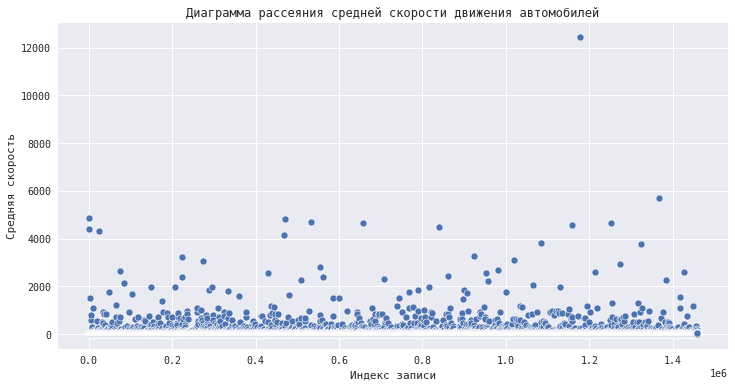

In [28]:
def show_scatterplot_of_avg_speed(data: pd.DataFrame):
    """Выводит диаграмму рассеяния средней скорости движения автомобилей

    Args:
        data (pd.DataFrame): таблица с данными
    """
    avg_speed = (data[F.TOTAL_DISTANCE.value] / data[F.TRIP_DURATION.value]) * 3.6

    fig, ax = plt.subplots(figsize=(12, 6))

    sns.scatterplot(x=avg_speed.index, y=avg_speed, ax=ax)
    ax.set_title('Диаграмма рассеяния средней скорости движения автомобилей')
    ax.set_xlabel('Индекс записи')
    ax.set_ylabel('Средняя скорость');

show_scatterplot_of_avg_speed(train_data)

Видим, что есть поездки со скоростью больше 1000 км/ч. и даже 12 000  км/ч.

Удаление перечисленных выше категорий поездок реализовано в методе `drop_outliers` класса `DataPreparation`.

Воспользуемся им и снова построим диаграмму.

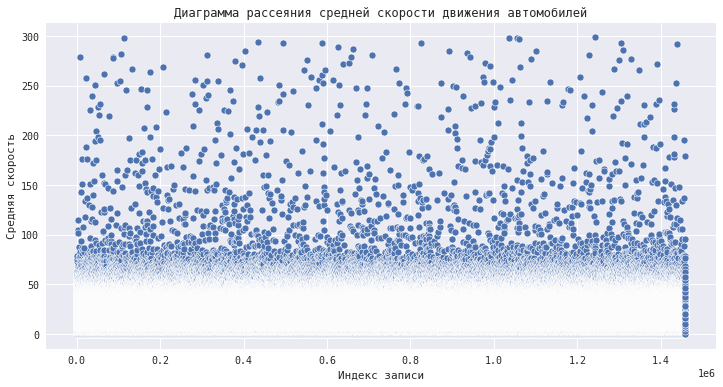

In [29]:
train_data = dataPreparation.drop_outliers(train_data)

show_scatterplot_of_avg_speed(train_data)

Теперь у нас средняя скорость от 0 до 300 км/ч.

## Разведывательный анализ данных (EDA) <a id="item_eda"></a>

Основной метрикой качества решения поставленной задачи будет **RMSLE (Root Mean Squared Log Error)**, \
которая вычисляется на основе целевой переменной в логарифмическом масштабе.

Поэтому будем рассматривать при анализе логарифм в качестве целевого признака.\
Создадим новый признак из целевого по формуле:

$$ trip\_duration\_log = log(trip\_duration+1), $$

где под $log$ подразумевается натуральный логарифм. 

Добавление данного признака реализовано в методе `add_target_log_feature` класса `DataPreparation`.

In [30]:
train_data = dataPreparation.add_target_log_feature(train_data)

### Тепловая карта корреляции признаков <a id="item_corr"></a>

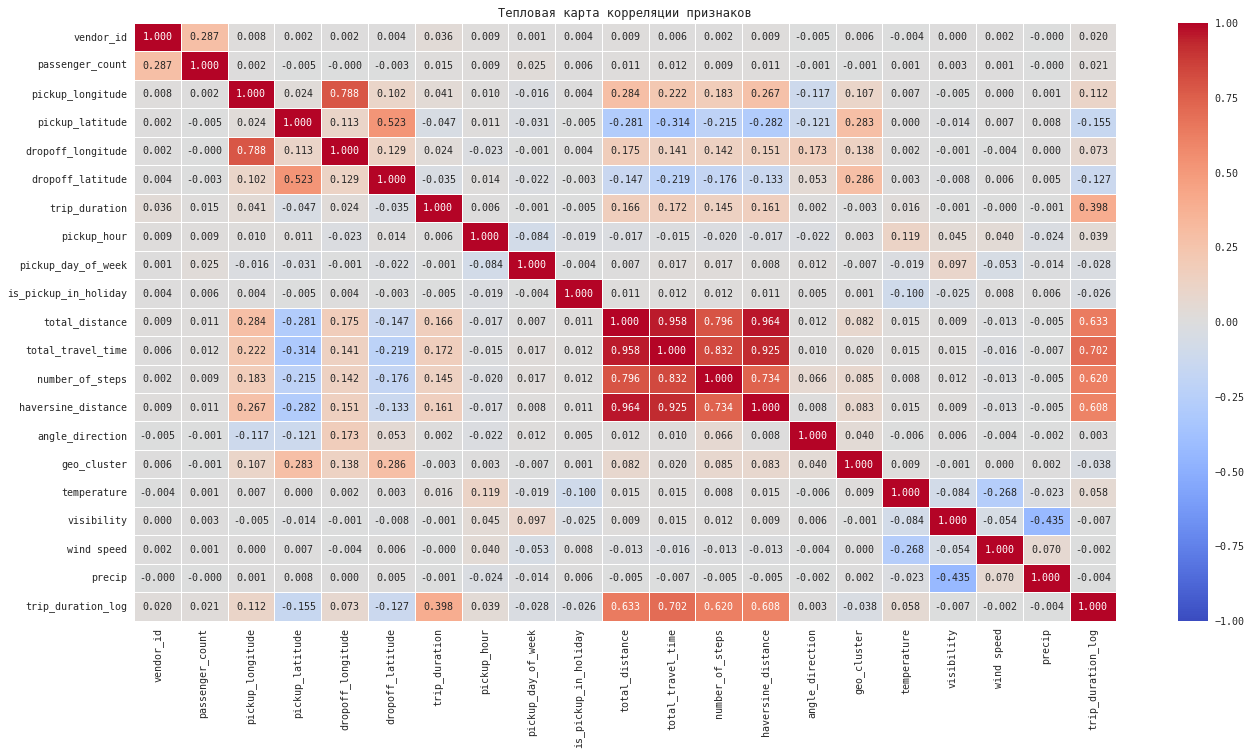

In [31]:
graphs.show_heatmap(
    train_data.corr(),
    'Тепловая карта корреляции признаков',
    is_corr_matrix = True,
)

С признаком  `trip_duration_log` больше других коррелируют следующие признаки:
- `total_travel_time`
- `total_distance`
- `number_of_steps`
- `haversine_distance`
- `trip_duration` - исходный целевой признак до логарифмирования. \
Что примечательно, корреляция с ним меньше, чем с созданными признаками, перечисленными выше.

Также в данных есть признаки с мультикорреляцией (значение больше 0.7)

### Распределение целевого признака в логарифмическом масштабе <a id="item_distribution_log_target"></a>

Исследуем распределение преобразованного целевого признака.

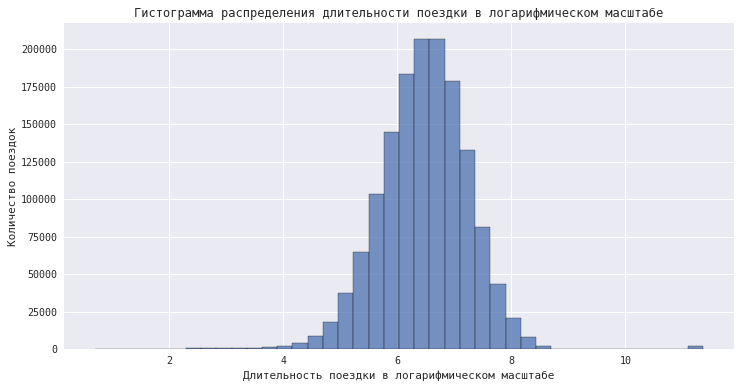

In [32]:
graphs.show_histplot(
    train_data,
    F.TRIP_DURATION_LOG.value,
    'Гистограмма распределения длительности поездки в логарифмическом масштабе',
    'Длительность поездки в логарифмическом масштабе',
    'Количество поездок',
)

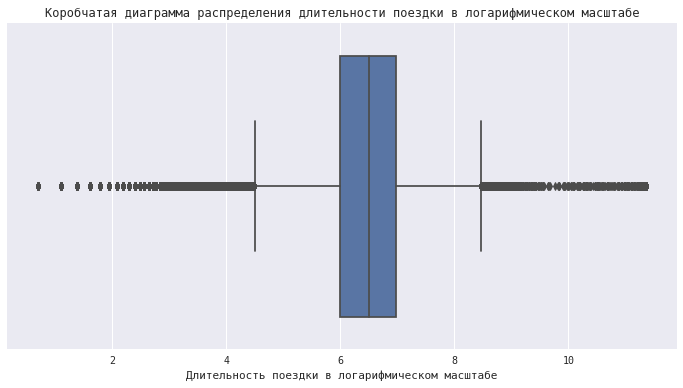

In [33]:
graphs.show_boxplot(
    train_data,
    F.TRIP_DURATION_LOG.value,
    'Коробчатая диаграмма распределения длительности поездки в логарифмическом масштабе',
    'Длительность поездки в логарифмическом масштабе',
)

Распределение похоже на нормальное. \
Проверим, является ли оно таким.

Для проверки используем тест Д’Агостино-Пирсона (`scipy.stats.normaltest`) при уровне значимости $\alpha=0.05$.

In [34]:
statistic, p_value = stats.normaltest(train_data[F.TRIP_DURATION_LOG.value])
print('p_value = ', p_value)

p_value =  0.0


Значение `p_value` меньше выбранного порога $0.05$, распределение не является нормальным.

### Распределение поездок между таксопарками <a id="item_vendor"></a>

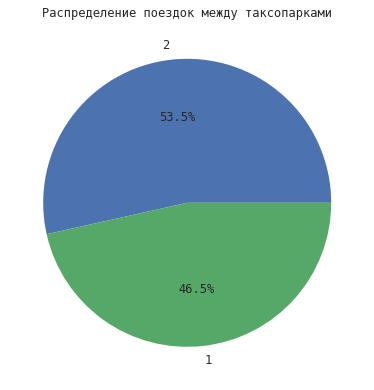

In [35]:
graphs.show_pie(train_data, F.VENDOR_ID.value, 'Распределение поездок между таксопарками')

Доли поездок для обоих таксопарков примерно одинаковы.

### Сравнение длительности поездки в логарифмическом масштабе в зависимости от таксопарка <a id="item_target_for_vendor"></a>

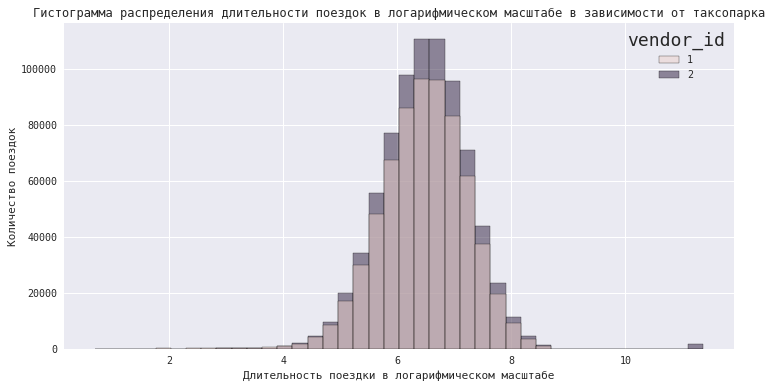

In [37]:
graphs.show_histplot(
    train_data, 
    F.TRIP_DURATION_LOG.value,
    'Гистограмма распределения длительности поездок в логарифмическом масштабе \
в зависимости от таксопарка',
    'Длительность поездки в логарифмическом масштабе',
    'Количество поездок',
    F.VENDOR_ID.value,
)

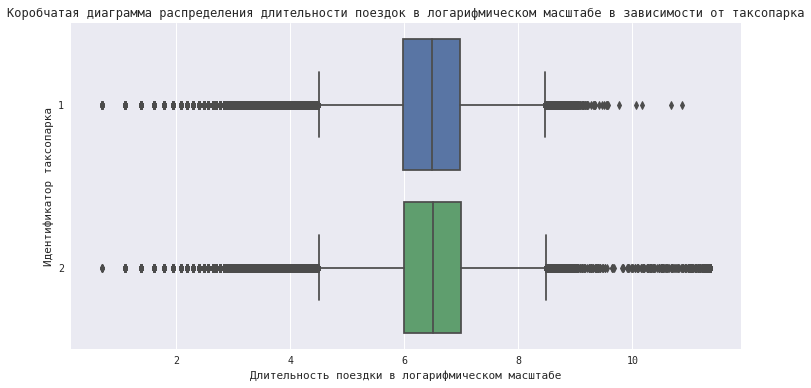

In [38]:
graphs.show_boxplot(
    train_data,
    F.TRIP_DURATION_LOG.value,
    'Коробчатая диаграмма распределения длительности поездок в логарифмическом масштабе \
в зависимости от таксопарка',
    'Длительность поездки в логарифмическом масштабе',
    'Идентификатор таксопарка',
    F.VENDOR_ID.value,
)

Распределения в группах практически не отличаются, признак `vendor_id` не имеет значения при определении длительности поездки. 

### Сравнение длительности поездки в логарифмическом масштабе в зависимости от отправки сообщения таксопарку <a id="item_target_for_store_flag"></a>

Рассмотрим распределение длительности поездок в зависимости от флага:

`store_and_fwd_flag` - флаг, который указывает, сохранилась ли запись о поездке\
в памяти транспортного средства перед отправкой поставщику\
(`Y` — хранить и пересылать, `N` — не хранить и не пересылать поездку)

Гистограмма распределения длительности поездок в логарифмическом масштабе в разрезе признка store_and_fwd_flag


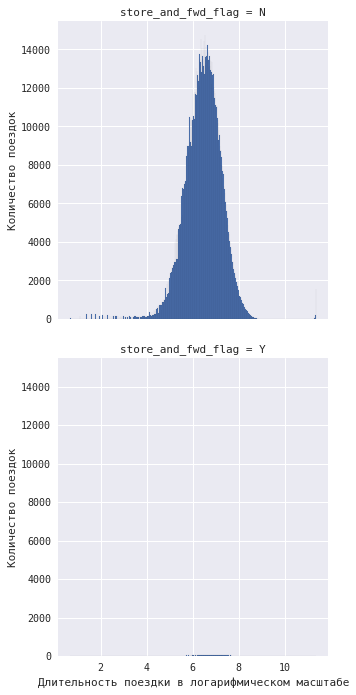

In [39]:
print(f'Гистограмма распределения длительности поездок в логарифмическом масштабе \
в разрезе признка {F.STORE_AND_FWD_FLAG.value}')

displot = sns.displot(
    data=train_data, 
    x=F.TRIP_DURATION_LOG.value, 
    row=F.STORE_AND_FWD_FLAG.value, 
    alpha=1, 
    kind='hist',    
)

displot.set_xlabels('Длительность поездки в логарифмическом масштабе')
displot.set_ylabels('Количество поездок');

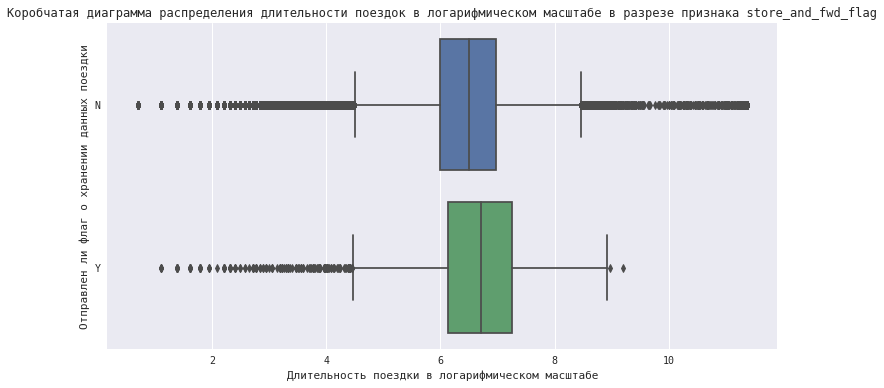

In [40]:
graphs.show_boxplot(
    train_data,
    F.TRIP_DURATION_LOG.value,
    f'Коробчатая диаграмма распределения длительности поездок в логарифмическом масштабе \
в разрезе признака {F.STORE_AND_FWD_FLAG.value}',
    'Длительность поездки в логарифмическом масштабе',
    'Отправлен ли флаг о хранении данных поездки',
    F.STORE_AND_FWD_FLAG.value,
)

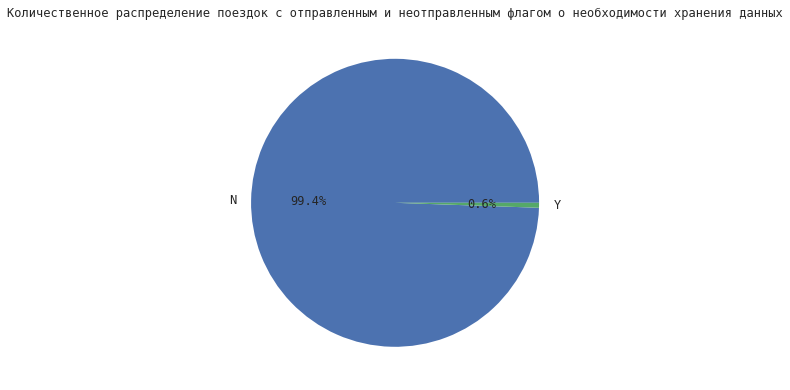

In [41]:
graphs.show_pie(
    train_data, 
    F.STORE_AND_FWD_FLAG.value, 
    'Количественное распределение поездок с отправленным и неотправленным флагом о необходимости хранения данных'
)

Видим, что поездок с отправленным флагом `store_and_fwd_flag` значительно меньше.\
И среди поездок с отправленным флагом практически нет длительных.\
Длительные поездки относятся к группе, для которой флаг не был отправлен.\
Медианные значения и квартили распределения их длительности находятся близко друг к другу.

### Количество поездок в зависимости от часа дня <a id="item_count_for_hour"></a>

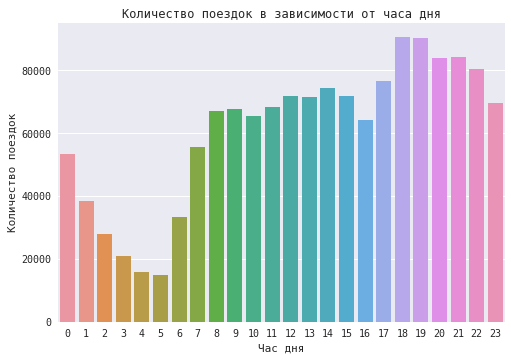

In [42]:
graphs.show_countplot(
    train_data,
    F.PICKUP_HOUR.value,
    'Количество поездок в зависимости от часа дня',
    'Час дня',
    'Количество поездок',
)

Наибольшее количество поездок совершается в вечернее время с 18 до 22 часов.\
Наименьшее с 2-х ночи до 5 утра.

### Медианная длительность поездки в зависимости от часа дня <a id="item_target_for_hour"></a>

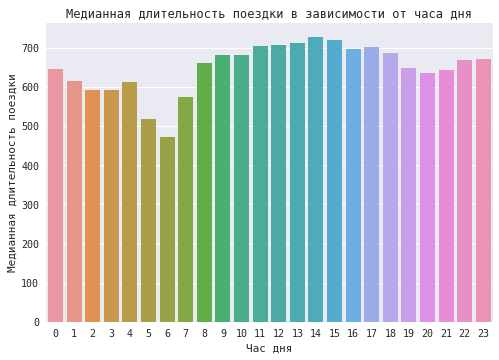

In [43]:
median_trip_duration_per_hour = train_data.groupby(F.PICKUP_HOUR.value)[F.TRIP_DURATION.value].median()

graphs.show_barplot(
    median_trip_duration_per_hour,
    'Медианная длительность поездки в зависимости от часа дня',
    'Час дня',
    'Медианная длительность поездки',
)

Наиболее короткие поездки с 5 до 7 часов утра.\
Наиболее длительные с 14 до 15 часов дня.

### Количество поездок в зависимости от дня недели <a id="item_count_for_day"></a>

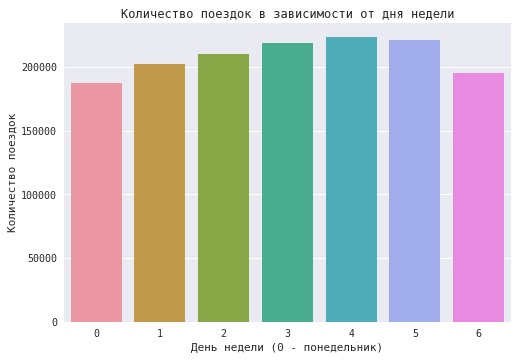

In [44]:
graphs.show_countplot(
    train_data,
    F.PICKUP_DAY_OF_WEEK.value, 
    'Количество поездок в зависимости от дня недели',
    'День недели (0 - понедельник)',
    'Количество поездок',
)

Больше всего поездок совершалось в пятницу и меньше всего в понедельник.

### Медианная длительность поездки в зависимости от дня недели <a id="item_target_for_day"></a>

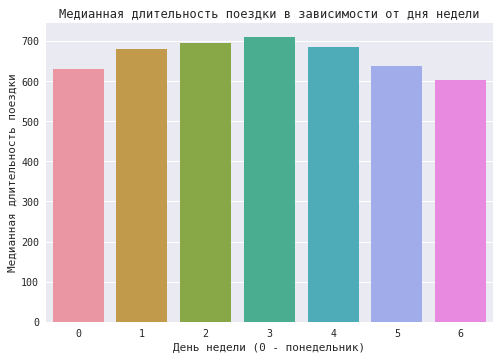

In [45]:
median_trip_duration_per_day = train_data.groupby(F.PICKUP_DAY_OF_WEEK.value)[F.TRIP_DURATION.value].median()

graphs.show_barplot(
    median_trip_duration_per_day,
    'Медианная длительность поездки в зависимости от дня недели',
    'День недели (0 - понедельник)',
    'Медианная длительность поездки',
)

Самые длительные поездки совершаются в четверг.\
Самые короткие в воскресенье.

### Медианная длительность поездки в зависимости от дня недели и часа дня <a id="item_target_for_hour_and_day"></a>

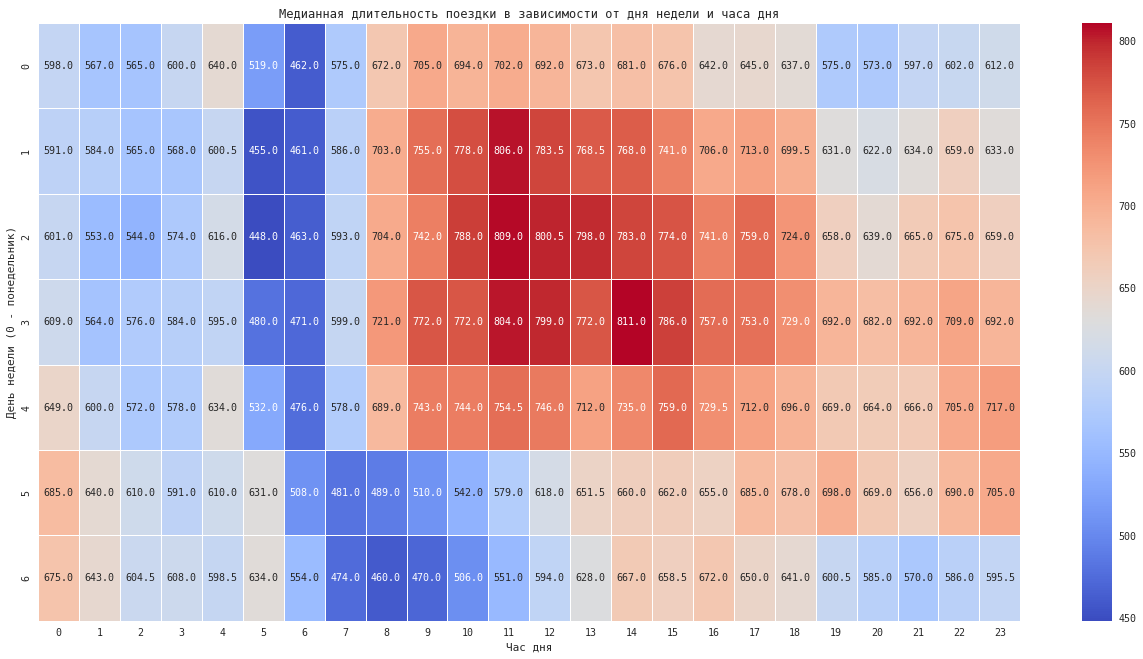

In [46]:
median_trip_duration_per_day_and_hour = pd.pivot_table(
    train_data,
    index=F.PICKUP_DAY_OF_WEEK.value,
    columns=F.PICKUP_HOUR.value,
    values=F.TRIP_DURATION.value,
    aggfunc='median',
)

graphs.show_heatmap(
    median_trip_duration_per_day_and_hour,
    'Медианная длительность поездки в зависимости от дня недели и часа дня',
    'Час дня',
    'День недели (0 - понедельник)',
)

- Самые продолжительные поездки наблюдаются с понедельника по пятницу в промежутке с 8 до 18 часов. 
- Самые короткие наблюдаются в утренние часы.

Скорее всего это связано с наличием или отсутствием пробок в это время.

### Географическое расположение точек кластеров поездок <a id="item_geo_cluster"></a>

Построим две диаграммы рассеяния.\
Первую  для точек широты и долготы начала  поездок.\
Вторую для точек широты и долготы завершения поездок.\
Выделим цветом точки разных кластеров.\
Будем брать только поездки в пределах Нью-Йорка.

Сначала сформируем необходимые данные, а потом выведем обе диаграммы рядом для сравнения.

In [47]:
# Границы Нью Йорка по широте
latitude_boundary_city = (40.63, 40.85)
# Границы Нью Йорка по долготе
longitude_boundary_city = (-74.03, -73.75)

# Палитра для всех кластеров
palette = {
    0: 'Aqua',
    1: 'Fuchsia', 
    2: 'Lime',
    3: 'Blue',
    4: 'Red',
    5: 'Green',
    6: 'Orange',
    7: 'Maroon',
    8: 'Indigo',
    9: 'Yellow',
}

def get_necessary_palette(necessary_clusters: np.ndarray) -> dict:
    """Возвращает только необходимые значения палитры

    Args:
        necessary_clusters (np.ndarray): номера кластеров, для которых нужны цвета

    Returns:
        dict: палитра с необходимыми цветами
    """
    return {cluster:color for cluster, color in palette.items() if cluster in necessary_clusters}

#### Данные для точек начала поездок

In [48]:
# Маска для ограничения широты
mask_latitude = ((latitude_boundary_city[0] < train_data[F.PICKUP_LATITUDE.value]) \
    & (train_data[F.PICKUP_LATITUDE.value] < latitude_boundary_city[1]))

# Маска для ограничения долготы
mask_longitude = ((longitude_boundary_city[0] < train_data[F.PICKUP_LONGITUDE.value]) \
    & (train_data[F.PICKUP_LONGITUDE.value] < longitude_boundary_city[1]))
    
# Применяем обе маски
pickup_city_data = train_data[mask_latitude & mask_longitude]

In [49]:
pickup_city_clusters = np.sort(pickup_city_data[F.GEO_CLUSTER.value].unique())

print(
    'Уникальные кластеры в пределах Нью-Йорка:', 
    pickup_city_clusters,
)

# палитра с цветами для представленных кластеров
pickup_city_palette = get_necessary_palette(pickup_city_clusters)

Уникальные кластеры в пределах Нью-Йорка: [0 1 3 4 5 6 7 9]


Кластеры 2 и 8 находятся за пределами Нью Йорка.

#### Данные для точек завершения поездок

In [50]:
# Маска для ограничения широты
mask_latitude = ((latitude_boundary_city[0] < train_data[F.DROPOFF_LATITUDE.value]) \
    & (train_data[F.DROPOFF_LATITUDE.value] < latitude_boundary_city[1]))

# Маска для ограничения долготы
mask_longitude = ((longitude_boundary_city[0] < train_data[F.DROPOFF_LONGITUDE.value]) \
    & (train_data[F.DROPOFF_LONGITUDE.value] < longitude_boundary_city[1]))
    
# Применяем обе маски
dropoff_city_data = train_data[mask_latitude & mask_longitude]

In [51]:
dropoff_city_clusters = np.sort(dropoff_city_data[F.GEO_CLUSTER.value].unique())

print(
    'Уникальные кластеры в пределах Нью-Йорка:', 
    dropoff_city_clusters,
) 

# получим палитру с цветами для представленных кластеров
dropoff_city_palette = get_necessary_palette(dropoff_city_clusters)

Уникальные кластеры в пределах Нью-Йорка: [0 1 3 4 5 7 9]


Кластеры 2, 6 и 8 находятся за пределами Нью Йорка.

#### Общий график

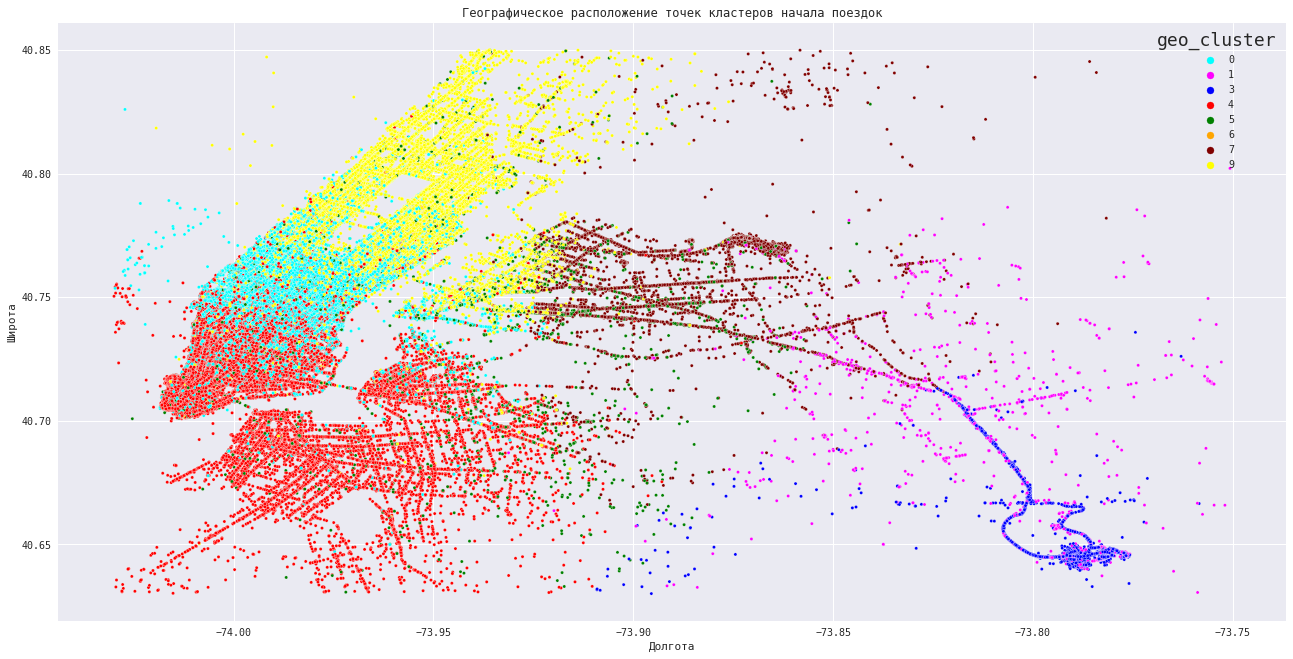

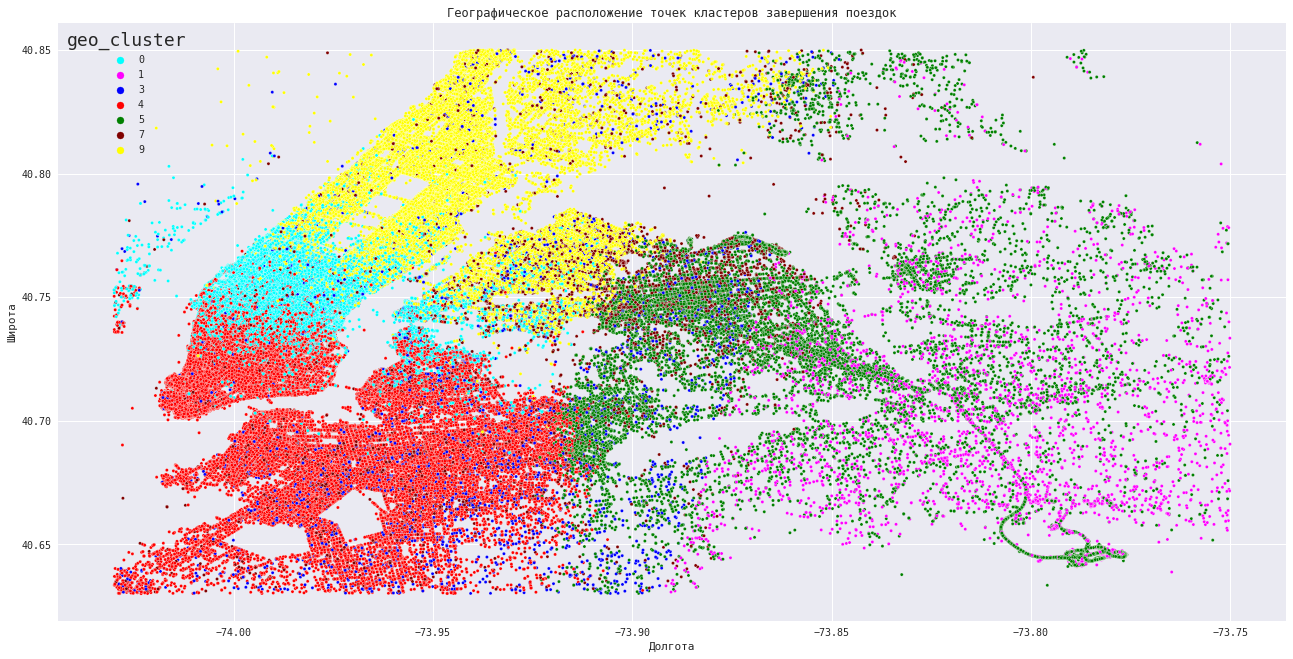

In [52]:
graphs.show_scatterplot(
    pickup_city_data,
    F.PICKUP_LONGITUDE.value,
    F.PICKUP_LATITUDE.value,
    F.GEO_CLUSTER.value,
    'Географическое расположение точек кластеров начала поездок',
    'Долгота',
    'Широта',
    pickup_city_palette,
)

graphs.show_scatterplot(
    dropoff_city_data,
    F.DROPOFF_LONGITUDE.value,
    F.DROPOFF_LATITUDE.value,
    F.GEO_CLUSTER.value,
    'Географическое расположение точек кластеров завершения поездок',
    'Долгота',
    'Широта',
    dropoff_city_palette,
)

![](./images/new-york-3d.jpg)

В целом расположение точек напоминает карту Нью-Йорка.\
На графике с началом поездок точки имеют бОльшую плотность в определенных областях,\
а на графике с завершением поездок плотность их более разрежена.\
Можно предположить, что чаще такси вызывается в общественные заведения, а потом развозит людей по домам.\
Общественные заведения расположены более плотно, а жилые строения более рассредоточены.

## Отбор и преобразование признаков <a id="item_fi"></a>

### Удаление лишних признаков <a id="item_drop_features"></a>

Удалим следующие признаки:
- `id` - Идентификатор поездки. Не несет полезной информации.
- `dropoff_datetime` - Дата и время, когда счётчик был отключён. \
Признак будет недоступен при реальном определении длительности поездки.
- `pickup_datetime` - Дата и время, когда был включён счётчик поездки. \
Всю полезную информацию мы из него уже вынули.
- `pickup_date` - дата включения счётчика/начала поездки (без времени). \
Также вынули всю полезную информацию.
- `trip_duration` - исходный признак длительности поездки, который мы перевели в логарифмический масштаб (`trip_duration_log`)

Удаление этих признаков реализовано в методе `drop_unnecessary_features` класса `DataPreparation`.\
Воспользуемся им.

In [53]:
train_data = dataPreparation.drop_unnecessary_features(train_data)

### Кодирование категориальных признаков <a id="item_encoding_features"></a>

В наших данных к категориальным можно отнести следующие признаки:

- `vendor_id`;
- `store_and_fwd_flag`;
- `pickup_day_of_week`;
- `geo_cluster`;
- `events`.

Первые два (`vendor_id` и `store_and_fwd_flag`) из них являются бинарными (имеют два уникальных значения). \
Перекодирование этих признаков реализовано в методе `encoding_binary_features` класса `DataPreparation`.\
Воспользуемся им.

In [54]:
train_data = dataPreparation.encoding_binary_features(train_data)

Для остальных признаков подойдет однократное кодирование.\
Создание обученного объекта класса `OneHotEncoder` для кодирования тренировочных и тестовых данных\
реализовано в методе `set_one_hot_encoder` класса `DataPreparation`.\
А перекодирование признаков - в методе `encoded_categorical_features` того же класса.\
Воспользуемся ими.

In [55]:
dataPreparation.set_one_hot_encoder(train_data)

train_data = dataPreparation.encoded_categorical_features(train_data)

In [56]:
train_data.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_hour,is_pickup_in_holiday,total_distance,...,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,events_None,events_Rain,events_Snow
0,1,1,-73.982155,40.767937,-73.964630,40.765602,0,17,0,2009.1,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1,0,1,-73.980415,40.738564,-73.999481,40.731152,0,0,0,2513.2,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1,1,-73.979027,40.763939,-74.005333,40.710087,0,11,0,11060.8,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,1,-74.010040,40.719971,-74.012268,40.706718,0,19,0,1779.4,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,1,1,-73.973053,40.793209,-73.972923,40.782520,0,13,0,1614.9,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0


Данные успешно перекодировались.

> Все предыдущие манипуляции с данными реализованы в методе `prepare_data` класса `DataPreparation`. \
В дальнейшем воспользуемся им для преобразования тестовых данных.

### Отбор лучших предикторов <a id="item_best_predictors"></a>

Сформируем матрицу наблюдений `X`, \
и вектор целевой переменной в логарифмическом масштабе `y_log`. 

In [57]:
X, y_log = dataPreparation.get_predictors_and_target(train_data)

Все модели будем обучать на логарифмированной версии `y_log`.

Так как набор данных довольно большой (почти 1.5 миллиона наблюдений), используем **hold-out**-валидацию.

Разобьем выборку на обучающую и валидационную.

In [58]:
X_train, X_valid, y_train_log, y_valid_log = dataPreparation.get_train_and_test_split(X, y_log)

# Запомним таблицы с полным набором признаков
X_train_all_features = X_train
X_valid_all_features = X_valid

Теперь отберем лучшие для предсказания признаки с помощью алгоритма `SelectKBest`.

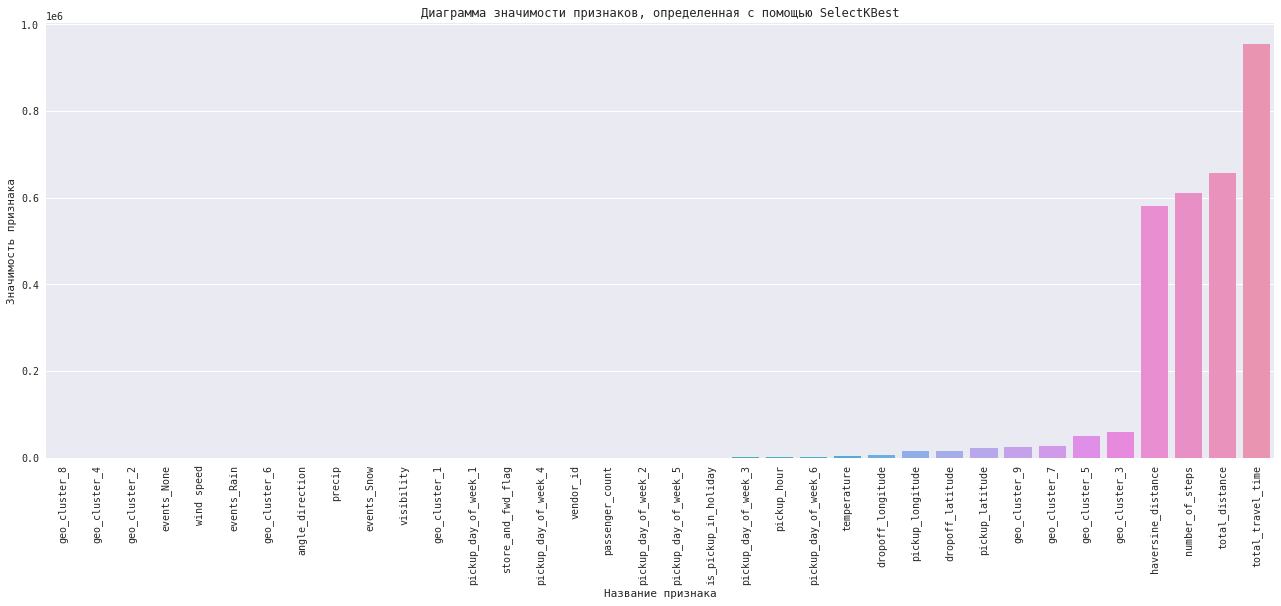

Пары мультиколлинеарных признаков:


[(['pickup_longitude', 'dropoff_longitude'], 0.75),
 (['pickup_longitude', 'geo_cluster_2'], -0.75),
 (['dropoff_longitude', 'geo_cluster_2'], -0.75),
 (['total_distance', 'total_travel_time'], 0.96),
 (['total_distance', 'number_of_steps'], 0.8),
 (['total_distance', 'haversine_distance'], 0.97),
 (['total_travel_time', 'number_of_steps'], 0.83),
 (['total_travel_time', 'haversine_distance'], 0.93),
 (['number_of_steps', 'haversine_distance'], 0.74),
 (['events_None', 'events_Rain'], -0.9)]

In [59]:
# Выведем диаграмму значимости признаков и пары мультиколлинеарных признаков
graphs.show_best_and_multicolinear_features(X_train, y_train_log)

Исключим признаки, которые дают мультиколлинеарность и являются менее ценными.

In [60]:
columns_to_drop = [
    'events_None',
    'haversine_distance',
    'number_of_steps',
    'total_distance',
    'geo_cluster_2',
    'dropoff_longitude',
]

X_train_best_features = X_train.drop(columns=columns_to_drop)

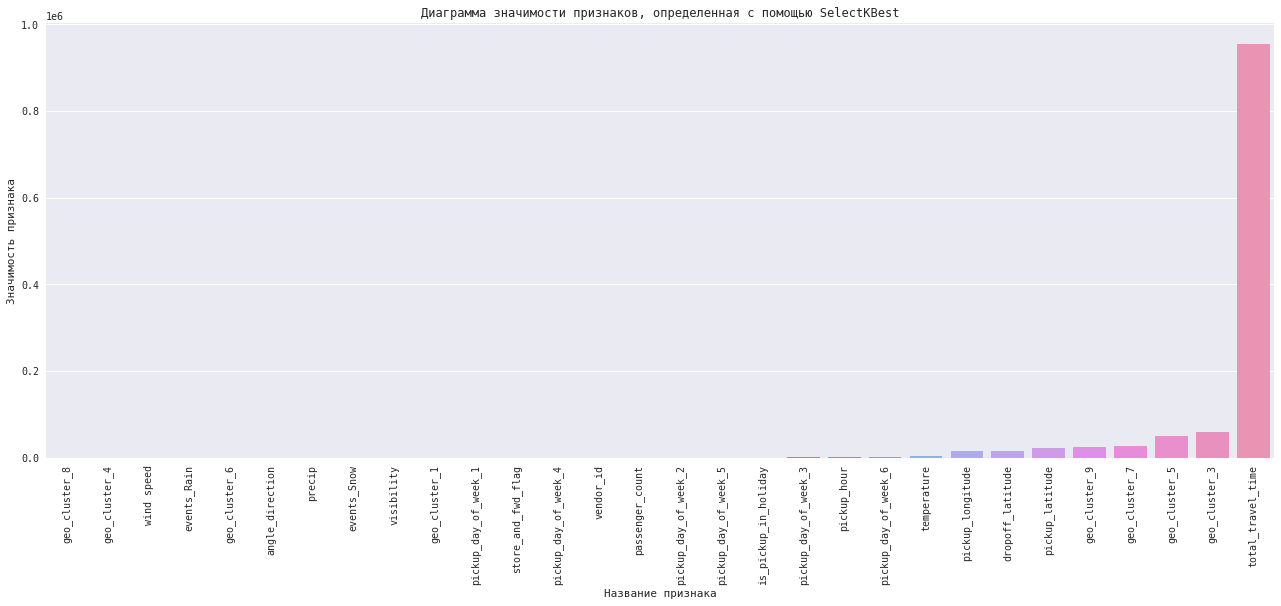

Пары мультиколлинеарных признаков:


[]

In [61]:
# Снова выведем диаграмму значимости признаков и пары мультиколлинеарных признаков
graphs.show_best_and_multicolinear_features(X_train_best_features, y_train_log)

Мультиколлинеарные признаки ушли.\
Из оставшихся признаков возьмем первые 15.

In [62]:
selector = feature_selection.SelectKBest(feature_selection.f_regression, k=15)
selector.fit(X_train_best_features, y_train_log)
best_feature_names = selector.get_feature_names_out()

# Запомним лучшие предикторы
dataPreparation.set_best_feature_names(best_feature_names)

In [63]:
print('Лучшие предикторы:')
display(best_feature_names)

Лучшие предикторы:


array(['pickup_longitude', 'pickup_latitude', 'dropoff_latitude',
       'pickup_hour', 'is_pickup_in_holiday', 'total_travel_time',
       'temperature', 'pickup_day_of_week_2', 'pickup_day_of_week_3',
       'pickup_day_of_week_5', 'pickup_day_of_week_6', 'geo_cluster_3',
       'geo_cluster_5', 'geo_cluster_7', 'geo_cluster_9'], dtype=object)

In [64]:
# Оставим в таблицах только лучшие признаки
X_train = dataPreparation.get_best_features(X_train)
X_valid = dataPreparation.get_best_features(X_valid)

### Нормализация признаков <a id="item_norm"></a>

Выполним нормализацию признаков с помощью `MinMaxScaler`.

In [65]:
# Обучим и запомним объект класса MinMaxScaler для масштабирования данных
dataPreparation.set_min_max_scaler(X_train)

# Получим масштабированные данные
X_train = dataPreparation.get_scaled_data(X_train)
X_valid = dataPreparation.get_scaled_data(X_valid)

## Решение задачи регрессии <a id="item_regression"></a>

### Описание метрики (RMSLE) <a id="item_rmsle"></a>

В [соревнованиях на Kaggle](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/overview) в качестве метрики взята RMSLE (Root Mean Squared Log Error), \
которая вычисляется как:

$$ RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (log (y_i + 1) - log (\hat{y}_i + 1))^2}, $$

где \
$y_i$ — истинная длительность $i$-й поездки на такси (`trip_duration`),\
$\hat{y}_i$  — предсказанная моделью длительность $i$-й поездки на такси.

Логарифмирование целевого признака мы уже провели, \
поэтому будет достаточно вычислить метрику **RMSE** для модели, \
обученной прогнозировать длительность поездки такси в логарифмическом масштабе:

$$ z_i = log (y_i + 1) $$

$$ RMSLE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (z_i - \hat{z}_i)^2} = \sqrt{MSE(z_i, \hat{z}_i)} $$

Расчет данной метрики реализован в функции `get_rmsle` в файле `./helpers/common.py`.

In [66]:
# Создадим таблицу, в которой будем хранить метрики для моделей и время обучения
rmsle_metrics_data = pd.DataFrame({
    'model': [],
    'rmsle_train': [],
    'rmsle_valid': [],
    'lead_time': [],
})

### Линейная регрессия <a id="item_lr"></a>

Построим модель линейной регрессии.

In [67]:
start_time = time.time()

# Создаем объект класса LinearRegression
linear_regression_model = linear_model.LinearRegression()
# Обучаем на тренировочной выборке
linear_regression_model.fit(X_train, y_train_log)
# Делаем предсказание на тренировочной выборке
y_train_pred = linear_regression_model.predict(X_train)

# Считаем RMSLE
rmsle_lr_train = get_rmsle(y_train_pred, y_train_log)
print_rmsle(rmsle_lr_train)

end_time = time.time()
lead_time = end_time - start_time
print_lead_time(lead_time)

RMSLE на тренировочной выборке:  0.5433392782299596
Время выполнения:  0:00:00.782967


In [68]:
# Делаем предсказание на валидационной выборке
y_valid_pred = linear_regression_model.predict(X_valid)

# Считаем RMSLE
rmsle_lr_valid = get_rmsle(y_valid_pred, y_valid_log)
print_rmsle(rmsle_lr_valid, True)

RMSLE на валидационной выборке:  0.5456374540066755


In [69]:
# Запомним значения метрик
rmsle_metrics_data = add_metric_to_data(
    rmsle_metrics_data, 
    ['LinearRegression', rmsle_lr_train, rmsle_lr_valid, lead_time]
)
rmsle_metrics_data

,model,rmsle_train,rmsle_valid,lead_time
0,LinearRegression,0.543339,0.545637,0.782967


In [70]:
print('Свободный коэффициент линейной регрессии: ', linear_regression_model.intercept_)

Свободный коэффициент линейной регрессии:  -3.5663603967522075


In [71]:
print('Коэффициенты линейной регрессии: ')
display(linear_regression_model.coef_)

Коэффициенты линейной регрессии: 


array([-7.05800247, 13.02971795,  8.75645637,  0.10837768, -0.09948997,
        9.61550496,  0.16299281,  0.04078918,  0.04046473, -0.06383053,
       -0.14170242, -0.83607512, -0.49244402, -0.2912196 , -0.08821074])

Коэффициенты не сильно расходятся по диапазону, модель можно считать устойчивой.

### Полиномиальная регрессия второй степени <a id="item_pr2"></a>

Попробуем уменьшить ошибку прогноза, воспользовавшись полиномиальной регрессией.\
Сгенерируем полиномиальные признаки второй степени с помощью класса `PolynomialFeatures`.

In [72]:
# Создаем объект класса PolynomialFeatures для генерации полиномиальных признаков второй степени
polynomial_features_generator_2 = preprocessing.PolynomialFeatures(degree=2, include_bias=False)
# Обучаем созданный объект
polynomial_features_generator_2.fit(X_train)
# Добавляем признаки в тренировочную и тестовую таблицы
X_train_poly_2 = polynomial_features_generator_2.transform(X_train)
X_valid_poly_2 = polynomial_features_generator_2.transform(X_valid)

print('Количество признаков: ', X_train_poly_2.shape[1])

Количество признаков:  135


In [73]:
start_time = time.time()

# Создаем модель линейной регрессии
linear_regression_poly_2_model = linear_model.LinearRegression()
# Обучаем на полиномиальных признаках 2-й степени
linear_regression_poly_2_model.fit(X_train_poly_2, y_train_log)
# Получаем предсказание
y_train_pred = linear_regression_poly_2_model.predict(X_train_poly_2)

# Считаем метрику
rmsle_pr2_train = get_rmsle(y_train_pred, y_train_log)
print_rmsle(rmsle_pr2_train)

end_time = time.time()
lead_time = end_time - start_time
print_lead_time(lead_time)

RMSLE на тренировочной выборке:  0.4833377484947581
Время выполнения:  0:00:14.401841


In [74]:
# Получаем предсказание для валидационной выборки
y_valid_pred = linear_regression_poly_2_model.predict(X_valid_poly_2)

rmsle_pr2_valid = get_rmsle(y_valid_pred, y_valid_log)
print_rmsle(rmsle_pr2_valid, True)

RMSLE на валидационной выборке:  0.49413509127915856


In [75]:
# Запомним значения метрик
rmsle_metrics_data = add_metric_to_data(
    rmsle_metrics_data, 
    ['Polynomial Regression 2', rmsle_pr2_train, rmsle_pr2_valid, lead_time]
)
rmsle_metrics_data

,model,rmsle_train,rmsle_valid,lead_time
0,LinearRegression,0.543339,0.545637,0.782967
1,Polynomial Regression 2,0.483338,0.494135,14.401841


Значение метрики улучшилось и переобучения не наблюдается.

### Полиномиальная регрессия третьей степени <a id="item_pr3"></a>

Построим полиномиальную регрессию третьей степени.

In [76]:
# Создаем объект класса PolynomialFeatures для генерации полиномиальных признаков третьей степени
polynomial_features_generator_3 = preprocessing.PolynomialFeatures(degree=3, include_bias=False)
# Обучаем созданный объект
polynomial_features_generator_3.fit(X_train)
# Добавляем признаки в тренировочную и тестовую таблицы
X_train_poly_3 = polynomial_features_generator_3.transform(X_train)
X_valid_poly_3 = polynomial_features_generator_3.transform(X_valid)

print('Количество признаков: ', X_train_poly_3.shape[1])

Количество признаков:  815


In [77]:
start_time = time.time()

# Создаем модель линейной регрессии
linear_regression_poly_3_model = linear_model.LinearRegression()
# Обучаем на полиномиальных признаках 3-й степени
linear_regression_poly_3_model.fit(X_train_poly_3, y_train_log)
# Получаем предсказание
y_train_pred = linear_regression_poly_3_model.predict(X_train_poly_3)

# Считаем метрику
rmsle_pr3_train = get_rmsle(y_train_pred, y_train_log)
print_rmsle(rmsle_pr3_train)

end_time = time.time()
lead_time = end_time - start_time
print_lead_time(lead_time)

RMSLE на тренировочной выборке:  0.45555157213386405
Время выполнения:  0:03:03.346827


In [78]:
# Получаем предсказание для валидационной выборки
y_valid_pred = linear_regression_poly_3_model.predict(X_valid_poly_3)

rmsle_pr3_valid = get_rmsle(y_valid_pred, y_valid_log)
print_rmsle(rmsle_pr3_valid, True)

RMSLE на валидационной выборке:  6.183692757418418


На тренировочной выборке значение метрики немного улучшилось.\
На тестовой наблюдаем явное переобучение.\
Попробуем воспользоваться $L_2$-регуляризацией.

In [79]:
start_time = time.time()

# Создаем модель с регуляризацией L2
ridge_poly_3_model = linear_model.Ridge(alpha=1)
# Обучаем на полиномиальных признаках 3-й степени
ridge_poly_3_model.fit(X_train_poly_3, y_train_log)
# Делаем предсказание
y_train_pred = ridge_poly_3_model.predict(X_train_poly_3)

# Считаем метрику
rmsle_rp3_train = get_rmsle(y_train_pred, y_train_log)
print_rmsle(rmsle_rp3_train)

end_time = time.time()
lead_time = end_time - start_time
print_lead_time(lead_time)

RMSLE на тренировочной выборке:  0.4667502982128457
Время выполнения:  0:00:43.419956


In [80]:
# Делаем предсказание для валидационной выборки
y_valid_pred = ridge_poly_3_model.predict(X_valid_poly_3)

# Считаем метрику
rmsle_rp3_valid = get_rmsle(y_valid_pred, y_valid_log)
print_rmsle(rmsle_rp3_valid, True)

RMSLE на валидационной выборке:  0.4696940698783195


In [81]:
# Запомним значения метрик
rmsle_metrics_data = add_metric_to_data(
    rmsle_metrics_data, 
    ['Ridge Polynomial 3', rmsle_rp3_train, rmsle_rp3_valid, lead_time]
)
rmsle_metrics_data

,model,rmsle_train,rmsle_valid,lead_time
0,LinearRegression,0.543339,0.545637,0.782967
1,Polynomial Regression 2,0.483338,0.494135,14.401841
2,Ridge Polynomial 3,0.466750,0.469694,43.419956


Мы решили проблему переобучения.\
И немного улучшили значение метрики на обеих выборках.

### Дерево решений <a id="item_tree"></a>

Построим модель дерева решений с помощью класса `DecisionTreeRegressor`.

In [82]:
# Настроим оптимизацию гиперпараметров для дерева решений
def optuna_dtr(trial):
  # Задаем пространства поиска гиперпараметров
  max_depth = trial.suggest_int('max_depth', 2, 20, 1)
  min_samples_leaf = trial.suggest_int('min_samples_leaf', 1, 20, 1)

  # Создаем модель
  model = tree.DecisionTreeRegressor(
      max_depth=max_depth,
      min_samples_leaf=min_samples_leaf,
      random_state=42,
  )
 
  # Применим cross validation
  score = model_selection.cross_val_score(
    model, 
    X_train, 
    y_train_log, 
    cv=5, 
    scoring='neg_mean_squared_error', 
    n_jobs=-1
  ).mean()

  return score

In [83]:
start_time = time.time()

# Создаем объект исследования
study_dtr = optuna.create_study(study_name='DecisionTreeRegressor', direction='maximize')

# Ищем лучшую комбинацию гиперпараметров 20 раз
study_dtr.optimize(optuna_dtr, n_trials=20)

end_time = time.time()
time_to_search_parameters = end_time - start_time

[I 2024-08-18 01:48:46,673] A new study created in memory with name: DecisionTreeRegressor
[I 2024-08-18 01:48:54,891] Trial 0 finished with value: -0.21830933527963733 and parameters: {'max_depth': 6, 'min_samples_leaf': 2}. Best is trial 0 with value: -0.21830933527963733.
[I 2024-08-18 01:48:59,991] Trial 1 finished with value: -0.22835237224547783 and parameters: {'max_depth': 5, 'min_samples_leaf': 10}. Best is trial 0 with value: -0.21830933527963733.
[I 2024-08-18 01:49:09,258] Trial 2 finished with value: -0.1920939325374815 and parameters: {'max_depth': 15, 'min_samples_leaf': 12}. Best is trial 2 with value: -0.1920939325374815.
[I 2024-08-18 01:49:16,951] Trial 3 finished with value: -0.1937660276898677 and parameters: {'max_depth': 11, 'min_samples_leaf': 8}. Best is trial 2 with value: -0.1920939325374815.
[I 2024-08-18 01:49:26,566] Trial 4 finished with value: -0.2145782399523827 and parameters: {'max_depth': 15, 'min_samples_leaf': 1}. Best is trial 2 with value: -0.192

In [84]:
print('Лучшие значения параметров: ', study_dtr.best_params)

Лучшие значения параметров:  {'max_depth': 14, 'min_samples_leaf': 16}


In [85]:
start_time = time.time()

# Создаем модель дерева решений
decision_tree_regressor_model = tree.DecisionTreeRegressor(
    # Используем лучшие найденные параметры
    **study_dtr.best_params,
    random_state=42
)
# Обучаем
decision_tree_regressor_model.fit(X_train, y_train_log)
# Делаем предсказание
y_train_pred = decision_tree_regressor_model.predict(X_train)

# Считаем метрику
rmsle_dtr_train = get_rmsle(y_train_pred, y_train_log)
print_rmsle(rmsle_dtr_train)

end_time = time.time()
time_to_fit = end_time - start_time
print_lead_time(time_to_fit)

RMSLE на тренировочной выборке:  0.41514986819918465
Время выполнения:  0:00:08.201583


In [86]:
# Делаем предсказание для валидационной выборки
y_valid_pred = decision_tree_regressor_model.predict(X_valid)

# Считаем метрику
rmsle_dtr_valid = get_rmsle(y_valid_pred, y_valid_log)
print_rmsle(rmsle_dtr_valid, True)

RMSLE на валидационной выборке:  0.4360309644577931


In [87]:
lead_time = time_to_search_parameters + time_to_fit

# Запомним значения метрик
rmsle_metrics_data = add_metric_to_data(
    rmsle_metrics_data, 
    ['DecisionTreeRegressor', rmsle_dtr_train, rmsle_dtr_valid, lead_time]
)
rmsle_metrics_data

,model,rmsle_train,rmsle_valid,lead_time
0,LinearRegression,0.543339,0.545637,0.782967
1,Polynomial Regression 2,0.483338,0.494135,14.401841
2,Ridge Polynomial 3,0.466750,0.469694,43.419956
3,DecisionTreeRegressor,0.415150,0.436031,173.116552


Значение метрики улучшилось.

### Случайный лес <a id="item_random_forest"></a>

In [88]:
start_time = time.time()

# Создаем модель случайного леса
random_forest_classifier_model = ensemble.RandomForestRegressor(
    criterion='squared_error',    
    n_estimators=200,
    max_depth=14,
    min_samples_leaf=16,
    random_state=42,
    verbose=True,
    n_jobs=-1,
)

# Обучаем
random_forest_classifier_model.fit(X_train, y_train_log)
# Делаем предсказание для тренировочной выборки
y_train_pred = random_forest_classifier_model.predict(X_train)

# Считаем метрику
rmsle_rfr_train = get_rmsle(y_train_pred, y_train_log)
print_rmsle(rmsle_rfr_train)

end_time = time.time()
lead_time = end_time - start_time
print_lead_time(lead_time)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=-1)]: Done  38 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 188 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  5.3min finished
[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    1.5s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    6.9s


RMSLE на тренировочной выборке:  0.4064901703588716
Время выполнения:  0:05:24.952704


[Parallel(n_jobs=6)]: Done 200 out of 200 | elapsed:    7.3s finished


In [89]:
# Делаем предсказание для валидационной выборки
y_valid_pred = random_forest_classifier_model.predict(X_valid)

# Считаем метрику
rmsle_rfr_valid = get_rmsle(y_valid_pred, y_valid_log)
print_rmsle(rmsle_rfr_valid, True)

[Parallel(n_jobs=6)]: Using backend ThreadingBackend with 6 concurrent workers.
[Parallel(n_jobs=6)]: Done  38 tasks      | elapsed:    0.5s
[Parallel(n_jobs=6)]: Done 188 tasks      | elapsed:    2.9s


RMSLE на валидационной выборке:  0.4233121783595271


[Parallel(n_jobs=6)]: Done 200 out of 200 | elapsed:    3.1s finished


In [90]:
# Запомним значения метрик
rmsle_metrics_data = add_metric_to_data(
    rmsle_metrics_data, 
    ['RandomForestRegressor', rmsle_rfr_train, rmsle_rfr_valid, lead_time]
)
rmsle_metrics_data

,model,rmsle_train,rmsle_valid,lead_time
0,LinearRegression,0.543339,0.545637,0.782967
1,Polynomial Regression 2,0.483338,0.494135,14.401841
2,Ridge Polynomial 3,0.466750,0.469694,43.419956
3,DecisionTreeRegressor,0.415150,0.436031,173.116552
4,RandomForestRegressor,0.406490,0.423312,324.952704


Значение метрики немного улучшилось.

### Градиентный бустинг над деревьями решений <a id="item_random_forest"></a>

In [91]:
start_time = time.time()

# Создаем модель градиентного бустинга над деревьями решений
gradient_boosting_regressor_model = ensemble.GradientBoostingRegressor(
    learning_rate=0.5,
    n_estimators=100,
    max_depth=6,
    min_samples_split=30,
    random_state=42,
    verbose=True,
)
# Обучаем
gradient_boosting_regressor_model.fit(X_train, y_train_log)
# Делаем предсказание для тренировочной выборки
y_train_pred = gradient_boosting_regressor_model.predict(X_train)

# Считаем метрику
rmsle_gbr_train = get_rmsle(y_train_pred, y_train_log)
print_rmsle(rmsle_gbr_train)

end_time = time.time()
lead_time = end_time - start_time
print_lead_time(lead_time)

      Iter       Train Loss   Remaining Time 
         1           0.3204            7.18m
         2           0.2355            7.09m
         3           0.2093            6.94m
         4           0.1991            6.85m
         5           0.1932            6.77m
         6           0.1898            6.68m
         7           0.1869            6.58m
         8           0.1854            6.52m
         9           0.1841            6.41m
        10           0.1825            6.32m
        20           0.1751            5.44m
        30           0.1718            4.72m
        40           0.1690            4.01m
        50           0.1672            3.33m
        60           0.1658            2.65m
        70           0.1647            1.98m
        80           0.1623            1.32m
        90           0.1609           39.59s
       100           0.1593            0.00s
RMSLE на тренировочной выборке:  0.39917253790040064
Время выполнения:  0:06:37.993920


In [92]:
# Делаем предсказание для валидационной выборки
y_valid_pred = gradient_boosting_regressor_model.predict(X_valid)

# Считаем метрику
rmsle_gbr_valid = get_rmsle(y_valid_pred, y_valid_log)
print_rmsle(rmsle_gbr_valid, True)

RMSLE на валидационной выборке:  0.4170518740329479


In [93]:
# Запомним значения метрик
rmsle_metrics_data = add_metric_to_data(
    rmsle_metrics_data, 
    ['GradientBoostingRegressor', rmsle_gbr_train, rmsle_gbr_valid, lead_time]
)
rmsle_metrics_data

,model,rmsle_train,rmsle_valid,lead_time
0,LinearRegression,0.543339,0.545637,0.782967
1,Polynomial Regression 2,0.483338,0.494135,14.401841
2,Ridge Polynomial 3,0.466750,0.469694,43.419956
3,DecisionTreeRegressor,0.415150,0.436031,173.116552
4,RandomForestRegressor,0.406490,0.423312,324.952704
5,GradientBoostingRegressor,0.399173,0.417052,397.993920


Значение метрики улучшилось.

Построим столбчатую диаграмму коэффициентов значимости каждого из факторов для построенной модели.

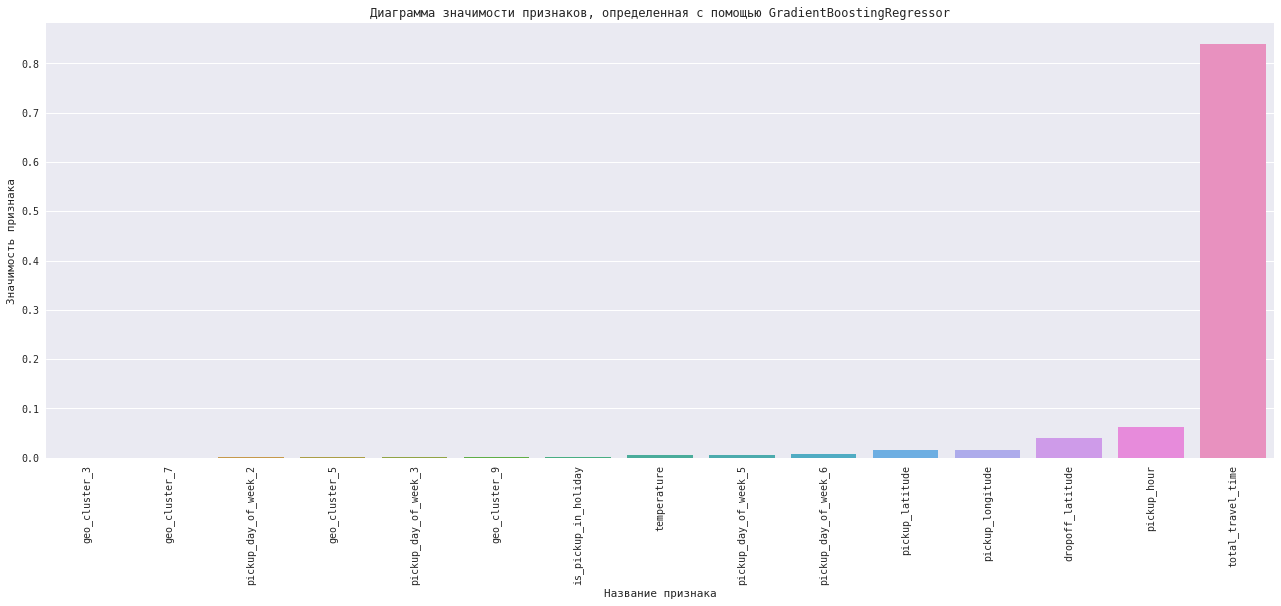

In [94]:
# Соберем в таблицу названия признаков и коэффициенты их значимости
features_significance_data = pd.DataFrame({ 
    'feature': X_train.columns, 
    'significance': gradient_boosting_regressor_model.feature_importances_,
})

# Отсортируем таблицу по значимости признаков
features_significance_data = features_significance_data.sort_values(by='significance')

# Выводим столбчатую диаграмму значимости признаков
graphs.show_barplot_of_feature_scores(
    features_significance_data['feature'],
    features_significance_data['significance'],
    'GradientBoostingRegressor',
)

Значимость признаков отличается от той, которая была определена с помощью `SelectKBest`.

`SelectKBest` определил наиболее значимыми признаки:
- `total_travel_time`, 
- `geo_cluster_3`, 
- `geo_cluster_5`.

А `GradientBoostingRegressor` выделил признаки:
- `total_travel_time`, 
- `pickup_hour`, 
- `dropoff_latitude`.

Но оба выделили наиболее значимым `total_travel_time`.

### Экстремальный градиентный бустинг `XGBoost` <a id="item_xg_boost"></a>

`XGBoost` — современная модель машинного обучения, \
которая является продолжением идеи градиентного бустинга Фридмана. \
У неё есть несколько преимуществ по сравнению с классической моделью \
градиентного бустинга из библиотеки `sklearn`:
- повышенная производительность благодаря параллелизации процесса обучения;
- повышенное качество решения за счёт усовершенствования алгоритма бустинга;
- меньшая склонность к переобучению и широкие возможности управления параметрами модели.

Перед обучением модели необходимо перевести наборы данных в тип данных `xgboost.DMatrix`:

In [95]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train, label=y_train_log)
dvalid = xgb.DMatrix(X_valid, label=y_valid_log)

Описание гиперпараметров модели приводится в документации [XGBoost Parameters](https://xgboost.readthedocs.io/en/stable/parameter.html) 

In [97]:
start_time = time.time()

# Гиперпараметры модели
xgb_params = {
    'min_child_weight': 20, 
    'eta': 0.1, 
    'colsample_bytree': 0.9, 
    'max_depth': 6, 
    'subsample': 0.9, 
    'lambda': 1, 
    'nthread': -1, 
    'booster': 'gbtree', 
    'eval_metric': 'rmse', 
    'objective': 'reg:squarederror',
}

# Тренировочная и валидационная выборки
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Обучаем модель XGBoost
xgb_model = xgb.train(
    params=xgb_params, # гиперпараметры модели
    dtrain=dtrain, # обучающая выборка
    num_boost_round=300, # количество моделей в ансамбле
    evals=watchlist, # выборки, на которых считается матрица
    early_stopping_rounds=20, # ранняя остановка
    maximize=False, # смена поиска максимума на минимум
    verbose_eval=50 # шаг, через который происходит отображение метрик
)

end_time = time.time()
lead_time = end_time - start_time
print_lead_time(lead_time)

[0]	train-rmse:0.74129	valid-rmse:0.74328
[50]	train-rmse:0.42878	valid-rmse:0.43248
[100]	train-rmse:0.41962	valid-rmse:0.42442
[150]	train-rmse:0.41517	valid-rmse:0.42101
[200]	train-rmse:0.41206	valid-rmse:0.41896
[250]	train-rmse:0.40936	valid-rmse:0.41737
[299]	train-rmse:0.40723	valid-rmse:0.41648
Время выполнения:  0:00:28.389099


In [98]:
# Делаем предсказание для тренировочной выборки
y_train_pred = xgb_model.predict(dtrain)

# Считаем метрику
rmsle_xgb_train = get_rmsle(y_train_pred, y_train_log)
print_rmsle(rmsle_xgb_train)

RMSLE на тренировочной выборке:  0.4072310017137631


In [99]:
# Делаем предсказание для валидационной выборки
y_valid_pred = xgb_model.predict(dvalid)

# Считаем метрику
rmsle_xgb_valid = get_rmsle(y_valid_pred, y_valid_log)
print_rmsle(rmsle_xgb_valid, True)

RMSLE на валидационной выборке:  0.41648283165172767


In [100]:
# Запомним значения метрик
rmsle_metrics_data = add_metric_to_data(
    rmsle_metrics_data, 
    ['XGBoost', rmsle_xgb_train, rmsle_xgb_valid, lead_time]
)
rmsle_metrics_data

,model,rmsle_train,rmsle_valid,lead_time
0,LinearRegression,0.543339,0.545637,0.782967
1,Polynomial Regression 2,0.483338,0.494135,14.401841
2,Ridge Polynomial 3,0.466750,0.469694,43.419956
3,DecisionTreeRegressor,0.415150,0.436031,173.116552
4,RandomForestRegressor,0.406490,0.423312,324.952704
5,GradientBoostingRegressor,0.399173,0.417052,397.993920
6,XGBoost,0.407231,0.416483,28.389099


Немного улучшилось значение метрики на валидационной выборке.

`XGBoost` может определять коэффициенты важности факторов и строить график в виде столбчатой диаграммы. \
Данная возможность реализована в функции `plot_importance()`:

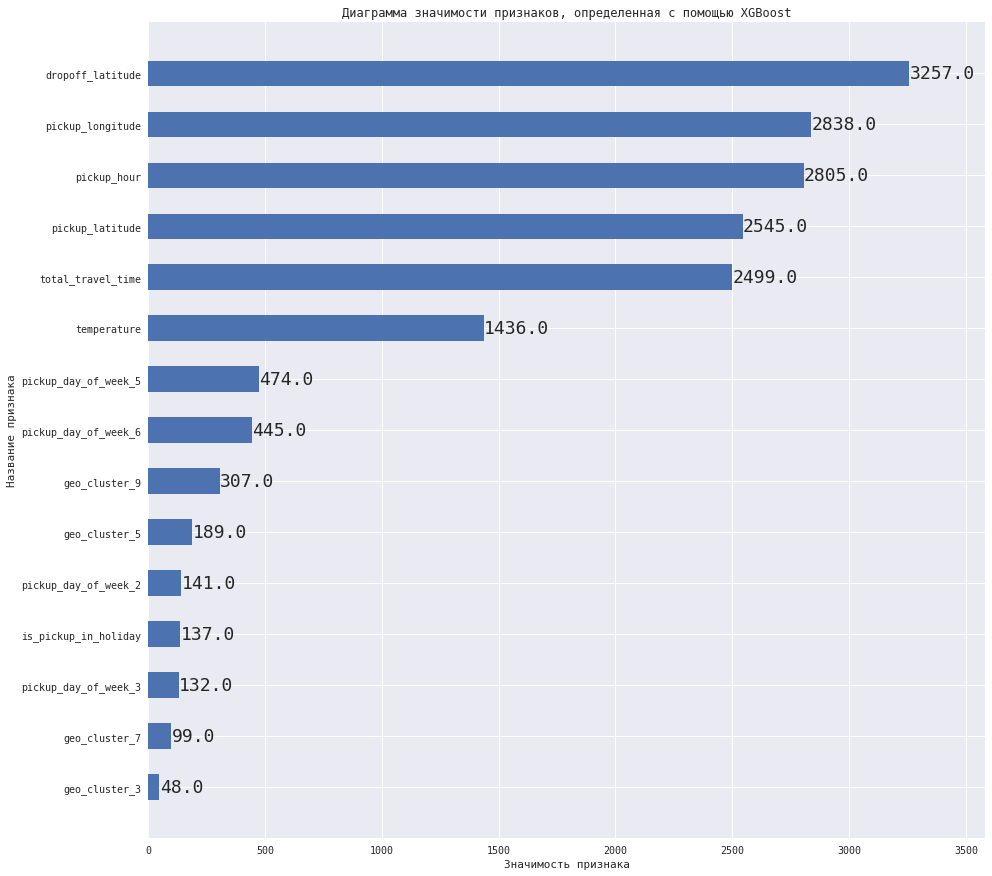

In [101]:
fig, ax = plt.subplots(figsize = (15, 15))
xgb.plot_importance(
    xgb_model, 
    ax=ax, 
    height=0.5, 
    title='Диаграмма значимости признаков, определенная с помощью XGBoost', 
    xlabel='Значимость признака',
    ylabel='Название признака',
);

Приоритет признаков значительно отличается от того, который выше был определен с помощью `SelectKBest` и `GradientBoostingRegressor`.\

Для сравнения посмотрим на первые 3 признака, выделенные каждым алгоритмом.

`SelectKBest` определил наиболее значимыми признаки:
- `total_travel_time`, 
- `geo_cluster_3`, 
- `geo_cluster_5`.

А `GradientBoostingRegressor` выделил признаки:
- `total_travel_time`, 
- `pickup_hour`, 
- `dropoff_latitude`.

`XGBoost` выделил:
- `dropoff_latitude`,
- `pickup_latitude`,
- `pickup_hour`.

`pickup_hour` и `dropoff_latitude` общие у алгоритмов градиентного бустинга над деревьями решений.

Возникает предположение, что в начале мы могли удалить признаки, которые `XGBoost` посчитал бы приоритетными.

Поскольку на работу алгоритма деревев решений не влияет мультиколлинеарность и масштабирование,\
ниже используем все признаки для построения модели `XGBoost` в их исходном виде.

### Экстремальный градиентный бустинг `XGBoost` на всех признаках <a id="item_xg_boost_all_features"></a>

In [102]:
# Создание матриц наблюдений в формате DMatrix
dtrain = xgb.DMatrix(X_train_all_features, label=y_train_log)
dvalid = xgb.DMatrix(X_valid_all_features, label=y_valid_log)

In [103]:
start_time = time.time()

# Гиперпараметры модели
xgb_params = {
    'min_child_weight': 20, 
    'eta': 0.1, 
    'colsample_bytree': 0.9, 
    'max_depth': 6, 
    'subsample': 0.9, 
    'lambda': 1, 
    'nthread': -1, 
    'booster': 'gbtree', 
    'eval_metric': 'rmse', 
    'objective': 'reg:squarederror',
}

# Тренировочная и валидационная выборки
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

# Обучаем модель XGBoost
xgb_model = xgb.train(
    params=xgb_params, # гиперпараметры модели
    dtrain=dtrain, # обучающая выборка
    num_boost_round=500, # количество моделей в ансамбле
    evals=watchlist, # выборки, на которых считается матрица
    early_stopping_rounds=20, # ранняя остановка
    maximize=False, # смена поиска максимума на минимум
    verbose_eval=50 # шаг, через который происходит отображение метрик
)

end_time = time.time()
lead_time = end_time - start_time
print_lead_time(lead_time)

[0]	train-rmse:0.74003	valid-rmse:0.74201
[50]	train-rmse:0.40690	valid-rmse:0.41020
[100]	train-rmse:0.39318	valid-rmse:0.39804
[150]	train-rmse:0.38711	valid-rmse:0.39327
[200]	train-rmse:0.38273	valid-rmse:0.39037
[250]	train-rmse:0.37943	valid-rmse:0.38841
[300]	train-rmse:0.37676	valid-rmse:0.38698
[350]	train-rmse:0.37450	valid-rmse:0.38617
[400]	train-rmse:0.37224	valid-rmse:0.38520
[450]	train-rmse:0.37007	valid-rmse:0.38440
[499]	train-rmse:0.36807	valid-rmse:0.38371
Время выполнения:  0:00:54.201299


In [104]:
# Делаем предсказание для тренировочной выборки
y_train_pred = xgb_model.predict(dtrain)

# Считаем метрику
rmsle_xgb_train = get_rmsle(y_train_pred, y_train_log)
print_rmsle(rmsle_xgb_train)

RMSLE на тренировочной выборке:  0.36806563643455115


In [105]:
# Делаем предсказание для валидационной выборки
y_valid_pred = xgb_model.predict(dvalid)

# Считаем метрику
rmsle_xgb_valid = get_rmsle(y_valid_pred, y_valid_log)
print_rmsle(rmsle_xgb_valid, True)

RMSLE на валидационной выборке:  0.3837084154431095


In [106]:
# Запомним значения метрик
rmsle_metrics_data = add_metric_to_data(
    rmsle_metrics_data, 
    ['XGBoost with all features', rmsle_xgb_train, rmsle_xgb_valid, lead_time]
)
rmsle_metrics_data

,model,rmsle_train,rmsle_valid,lead_time
0,LinearRegression,0.543339,0.545637,0.782967
1,Polynomial Regression 2,0.483338,0.494135,14.401841
2,Ridge Polynomial 3,0.466750,0.469694,43.419956
3,DecisionTreeRegressor,0.415150,0.436031,173.116552
4,RandomForestRegressor,0.406490,0.423312,324.952704
5,GradientBoostingRegressor,0.399173,0.417052,397.993920
6,XGBoost,0.407231,0.416483,28.389099
7,XGBoost with all features,0.368066,0.383708,54.201299


Значение метрики заметно улучшилось.

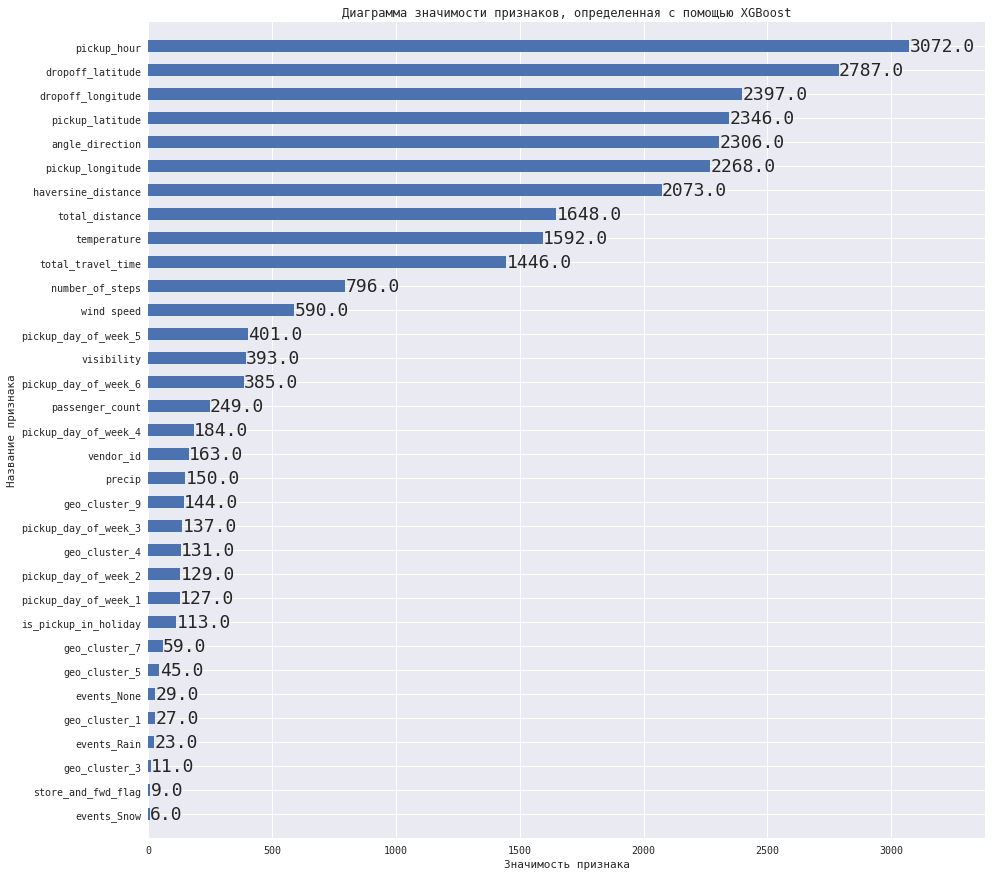

In [107]:
fig, ax = plt.subplots(figsize = (15, 15))
xgb.plot_importance(
    xgb_model, 
    ax=ax, 
    height=0.5, 
    title='Диаграмма значимости признаков, определенная с помощью XGBoost', 
    xlabel='Значимость признака',
    ylabel='Название признака',
);

Итак, из всех признаков `XGBoost` выделил наиболее значимыми:
- `pickup_hour`
- `dropoff_latitude`
- `dropoff_longitude` 

`dropoff_longitude` мы кстати удалили в начале как мультиколлинеарный.

### Выбор лучшей модели <a id="item_best_model"></a>

Посмотрим на метрики, которые мы получили.

In [109]:
rmsle_metrics_data

,model,rmsle_train,rmsle_valid,lead_time
0,LinearRegression,0.543339,0.545637,0.782967
1,Polynomial Regression 2,0.483338,0.494135,14.401841
2,Ridge Polynomial 3,0.466750,0.469694,43.419956
3,DecisionTreeRegressor,0.415150,0.436031,173.116552
4,RandomForestRegressor,0.406490,0.423312,324.952704
5,GradientBoostingRegressor,0.399173,0.417052,397.993920
6,XGBoost,0.407231,0.416483,28.389099
7,XGBoost with all features,0.368066,0.383708,54.201299


Построим тепловую карту для наглядности.

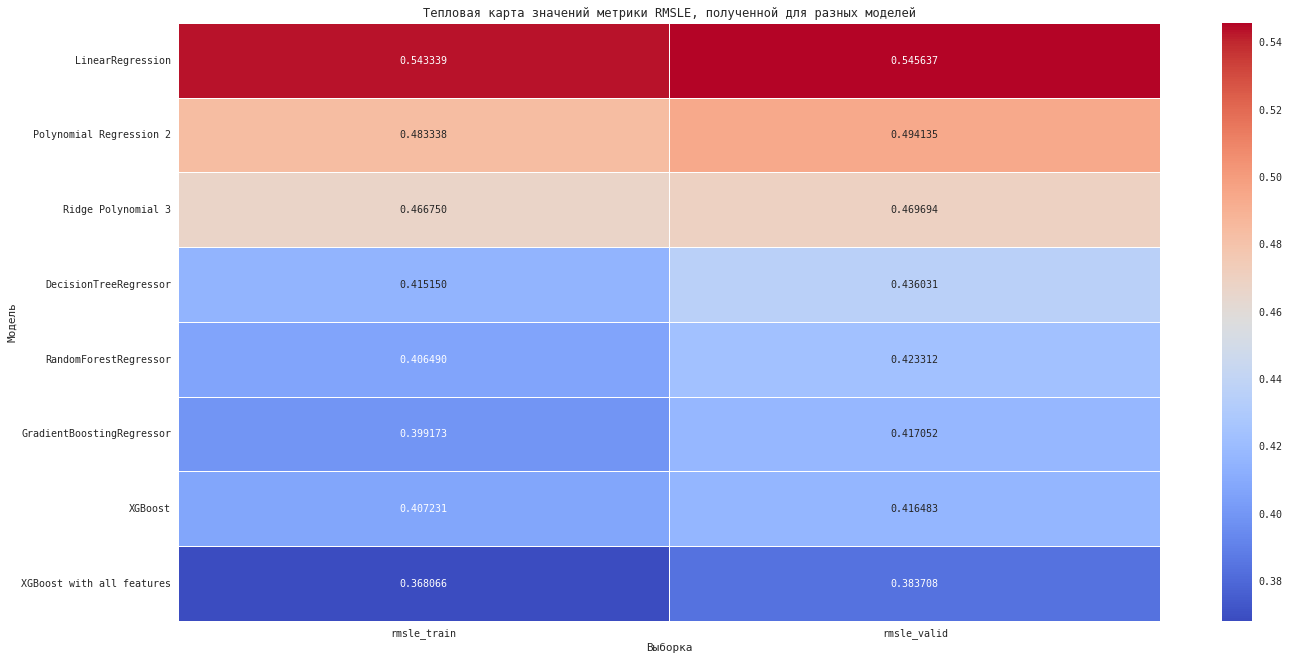

In [110]:
graphs.show_heatmap(
    rmsle_metrics_data.drop(columns=['lead_time']).set_index('model'),
    'Тепловая карта значений метрики RMSLE, полученной для разных моделей',
    'Выборка',
    'Модель',
    fmt='.6f',
)

Лучший результат по метрике показала модель `XGBoost`, построенная на всех признаках.\
Также этот алгоритм работает быстрее, чем `GradientBoostingRegressor`.\
Позже используем эту модель для предсказания на тестовой выборке.

### Расчет медианной абсолютной ошибки (MeAE) для лучшей модели <a id="item_meae"></a>

Метрика RMSLE используется в [соревновании](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/overview), из которого взяты данные.\
Поэтому результаты моделей мы сверяли с ней.\
Но она не является интерпретируемой.\
Хотелось бы узнать, на сколько минут ошибается наша лучшая модель.\
Посчитаем для нее значение медианной абсолютной ошибки (`MeAE`).

$$ MeAE = median (\left|y_i - \hat{y}_i \right|) $$

Целевую переменную и предсказания модели переведем \
из логарифмического масштаба в изначальный по следующей формуле:

$$ y_i = exp(z_i) - 1 $$

Данный перевод реализован в методе `get_source_target_feature` класса `DataPreparation`.\
Воспользуемся им.

In [111]:
y_valid_pred_source = dataPreparation.get_source_target_feature(y_valid_pred)
y_valid_source = dataPreparation.get_source_target_feature(y_valid_log)

meae = metrics.median_absolute_error(y_valid_pred_source, y_valid_source)

print(f'Медианная абсолютная ошибка составляет: {datetime.timedelta(seconds=round(meae))}.')

Медианная абсолютная ошибка составляет: 0:01:46.


То есть, медианная абсолютная ошибка составляет 1 минуту 46 секунд.\
Кажется, что это  неплохо.

## Предсказание для отложенного набора данных <a id="item_test_predict"></a>

Теперь сделаем предсказание для тестовой выборки из [соревнования](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/data).\
Скачать тестовый набор данных можно [здесь](https://disk.yandex.ru/d/8z_EHADqUtzbxQ).\
А файл с данными из OSRM API для тестовой выборки — [здесь](https://disk.yandex.ru/d/lnVaGKo7x3SqKg).

In [112]:
# Загрузим тестовые данные 
X_test = pd.read_csv('./data/Project5_test_data.csv')
X_test.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [113]:
# Сохраним столбец с идентификаторами, он будет нужен для формирования сабмита
X_test_id = X_test['id']

# Данные из OSRM API для тестовой выборки
osrm_data_test = pd.read_csv('./data/Project5_osrm_data_test.csv')
# Запомним таблицу с данными OSRM
dataPreparation.set_osrm_data(osrm_data_test)

Все преобразования, которые были выше сделаны для тренировочной таблице, \
продублированы в методе `prepare_data` класса `DataPreparation`.

In [114]:
# Преобразуем тестовые данные
X_test = dataPreparation.prepare_data(X_test, is_data_train=False)
X_test.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,pickup_hour,is_pickup_in_holiday,total_distance,...,geo_cluster_3,geo_cluster_4,geo_cluster_5,geo_cluster_6,geo_cluster_7,geo_cluster_8,geo_cluster_9,events_None,events_Rain,events_Snow
0,0,1,-73.988129,40.732029,-73.990173,40.756680,0,23,0,3795.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
1,0,1,-73.964203,40.679993,-73.959808,40.655403,0,23,0,2904.5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,0,1,-73.997437,40.737583,-73.986160,40.729523,0,23,0,1499.5,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3,1,1,-73.956070,40.771900,-73.986427,40.730469,0,23,0,7023.9,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
4,0,1,-73.970215,40.761475,-73.961510,40.755890,0,23,0,1108.2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [115]:
# Переведем матрицу наблюдений в формат DMatrix
dtest = xgb.DMatrix(X_test)

# Делаем предсказание для тестового набора данных
y_test_log_pred = xgb_model.predict(dtest)

# Переводим данные из логарифмического масштаба в исходный
y_test_pred = dataPreparation.get_source_target_feature(y_test_log_pred)

# Формируем датафрейм для сабмита
submission_xgb = pd.DataFrame({'id': X_test_id, 'trip_duration': y_test_pred})

# Сохраняем файл для сабмита
submission_xgb.to_csv('./data/submission_xgb.csv', index=False)

Полученный файл можно скачать [здесь](https://disk.yandex.ru/d/8cmbfQDMj5eSRg).\
Загружаем файл на [платформу](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/submissions) \
и получаем значение метрики.\
![](./images//kaggle_submission_xgb.png)

Срок соревнования закончился, поэтому отправить результат в [leaderboard](https://www.kaggle.com/competitions/nyc-taxi-trip-duration/leaderboard) не получится.\
Данная работа была тренировочной.\
На текущий момент метрика **0.39351** соответствует 430-му месту.\
![](./images/kaggle_leaderboard.png)

## Вывод <a id="item_conclusion"></a>

Лучший результат показала модель `XGBoost`, построенная на всех признаках.\
С ее помощью получили наименьшее значение метрики `RMSLE`:
- на тренировочной выборке **0.36807**
- на валидационной **0.38371**
- на тестовой выборке из соревнования **0.39351**

И по скорости вполне приемлемо - меньше минуты при 500-х моделях.